# i. Perkenalan

==================================================================================

Nama        : Nurdin Atid H

Datasets    : [credit_card_default]('https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-400803&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default')

===================================================================================

#### Pernyataan Masalah :
Dalam kehidupan sehari-hari saat ini menggunakan credit card merupakan hal yang lumrah dan merupakan pasar yang strategis untuk bisnis terkait, namun dibalik bisnis strategis resiko terbesarnya adalah ketidakmampuan klien untuk membayar cicilan kartu kredit tersebut, sehingga dibutuhkan langkah untuk memprediksi klien mana yang tidak mampu bembayar cicilan kartu kredit sehingga dapat dilakukan penanganan atau pencegahan. 

#### Tujuan : 

Tujuan utama adalah mengembangkan model prediksi yang akurat untuk mengidentifikasi pelanggan yang berpotensi gagal bayar.

### Penjabaran Masalah : 
- Dari data pelanggan, perlu diidentifikasi variabel-variabel yang dapat mempengaruhi peluang seorang pelanggan untuk gagal membayar.

- Perusahaan perlu mengembangkan model prediksi yang dapat mengestimasi risiko gagal bayar untuk setiap pelanggan.

- Mengidentifikasi model klasifikasi terbaik di antara Logistic Regression, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN) untuk memprediksi default_payment_next_month.

#### Solusi yang Dilakukan :
Untuk menyelesaikan penjabaran masalah ini, kami akan menggunakan : 
- Model terbaik dengan membandingkan  Model Logistic Regression, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN).
- Metrik evaluasi yang digunakan dalam konteks adalah recall

# ii. Query SQL

Data ini di ambil dari big querry bernama **credit_card_default** dengan sumber klik [link]('https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-400803&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default') 

Dari data tersebut diambil data dengan mengubah beberapa kolom agar sesuai dengan ketentuan 


| Kolom | Tipe Data Awal | Tipe Data Akhir |
|---------| --------- | ------------- |
| sex	| STRING |	INT |
| education_level	| STRING | INT |
| marital_status | STRING | INT |
| pay_5 | STRING | FLOAT |
| pay_6 | STRING | FLOAT |
| default_payment_next_month | STRING | INT |

Dengan limit jumlah data menjadi sebanyak nomor batch dikali dengan tahun lahir = 2 * 1991 = 3.982

Maka dilakukan seleksi dengan syntak sql sebagai berikut :

```sql
SELECT
  limit_balance,
  CAST(sex AS INT64) AS sex,
  CAST(education_level AS INT64) AS education_level,
  CAST(marital_status AS INT64) AS marital_status,
  age,
  pay_0,
  pay_2, 
  pay_3, 
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1, 
  bill_amt_2, 
  bill_amt_3, 
  bill_amt_4, 
  bill_amt_5, 
  bill_amt_6, 
  pay_amt_1, 
  pay_amt_2, 
  pay_amt_3, 
  pay_amt_4, 
  pay_amt_5, 
  pay_amt_6,
  CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 3982;

# iii. Import Libraries

In [1]:
# import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import pickle
import json
from feature_engine.outliers import Winsorizer  # Capping normal dan skewed distribution
from sklearn.preprocessing import MinMaxScaler  # scalling
from sklearn.preprocessing import MinMaxScaler  # MinMaxScaler

# import FE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# Check Performance Model against Train-Set
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


# iv. Data Loading



Pada bagian ini kita akan menampilkan data dari csv lalu mengcopy data tersebut agar data asli tidak berubah.

In [2]:
# Load dataset
#import data yang sudah di download dari kaggle|com
df = pd.read_csv('P1G5_Set_1_nurdin_atid.csv')

# Duplicate data ori
df_1 = df.copy()


Menampilkan 10 data paling atas

In [3]:
# tampilkan sepuluh data paling atas
df_1.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


Menampilkan 10 data paling bawah

In [4]:
# tampilkan sepuluh data paling bawah
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [5]:
# tampilkan data info
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

- Data terdiri dari 24 kolom.
- Bertipe Integer(64) 4 kolom ,Float(64) 20 kolom.
- Memiliki 2.965 baris

Dengan rincian kolom sebagai berikut : 

fullname |	description |
---------|--------------|
limit_balance|	Amount of given credit in NT dollars (includes individual and family/supplementary credit)|
sex	| Gender (1=male, 2=female)|
education_level	| Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)|
marital_status	| Marital status (1=married, 2=single, 3=others)|
age|	Age in years|
pay_0	|Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
pay_2	| Repayment status in August, 2005 (scale same as above)
pay_3	 |Repayment status in July, 2005 (scale same as above)
pay_4	|Repayment status in June, 2005 (scale same as above)
pay_5	|Repayment status in May, 2005 (scale same as above)
pay_6	|Repayment status in April, 2005 (scale same as above)
bill_amt_1|	Amount of bill statement in September, 2005 (NT dollar)
bill_amt_2|	Amount of bill statement in August, 2005 (NT dollar)
bill_amt_3 |	Amount of bill statement in July, 2005 (NT dollar)
bill_amt_4|	Amount of bill statement in June, 2005 (NT dollar)
bill_amt_5|	Amount of bill statement in May, 2005 (NT dollar)
bill_amt_6|	Amount of bill statement in April, 2005 (NT dollar)
pay_amt_1	|Amount of previous payment in September, 2005 (NT dollar)
pay_amt_2|	Amount of previous payment in August, 2005 (NT dollar)
pay_amt_3|	Amount of previous payment in July, 2005 (NT dollar)
pay_amt_4|	Amount of previous payment in June, 2005 (NT dollar)
pay_amt_5|	Amount of previous payment in May, 2005 (NT dollar)
pay_amt_6	|Amount of previous payment in April, 2005 (NT dollar)
default_payment_next_month	| Default payment (1=yes, 0=no)



In [6]:
df_1.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


Dari pengolahan describe diatas, dapat disimpulkan bahwa :

- Rata-rata limit_balance yaitu ada di rentan 163.369,3

- limit_balance tertinggi pada kolom limit_balance yaitu ada di rentan 800.000

- Sedangkan nilai terendah pada kolom limit_balance yaitu 10.000


jika mean dan median(50%) dari kolom limit_balance itu mirip angkanya, kemungkinan besar normal distribution dan jika jauh maka termasuk skew distribution. Dari data diatas hasinya menentukan bahwa datanya termasuk skew distribution.

# v. Exploratory Data Analysis (EDA)
Bagian ini berisi ekplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana dan lain sebagainya.

Text(0.5, 1.0, 'default_payment_next_month vc sex')

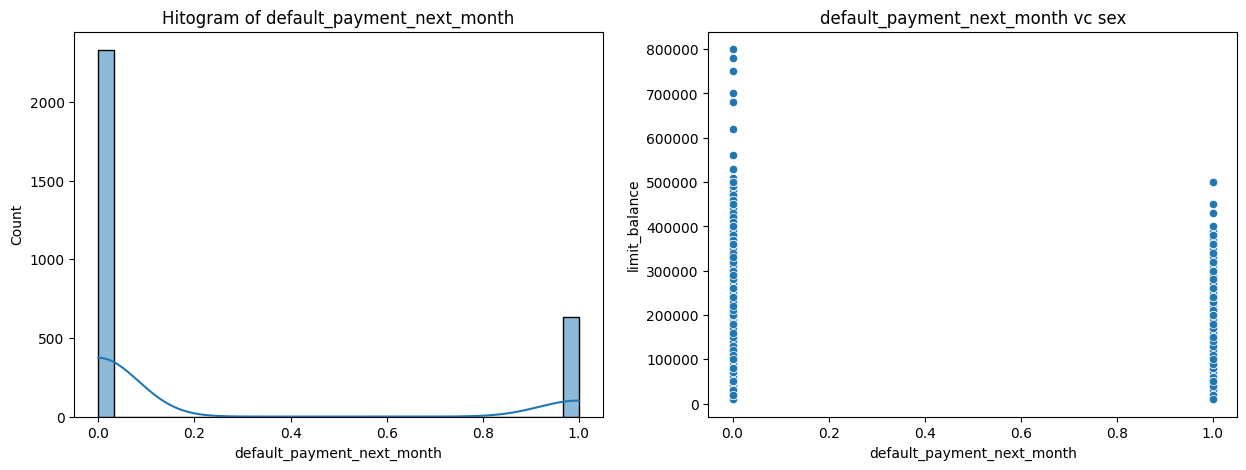

In [7]:
# membuat kanvas
plt.figure(figsize=(15,5))  

# membuat grafik
# Plot 1 taruh dikiri
plt.subplot(1, 2, 1)       
sns.histplot(df_1['default_payment_next_month'],kde=True, bins=30)   
plt.title('Hitogram of default_payment_next_month')

# Plot 1 taruh dikanan
plt.subplot(1, 2, 2)     #untuk bikin kolom 2
sns.scatterplot(x='default_payment_next_month',y='limit_balance',data=df_1)  #untuk bikin grafik
plt.title('default_payment_next_month vc sex')

Terlihat deafault paymen di dominasi dengan 0 yang artinya yang membayar lebih banyak dari pada yang gagal bayar.

In [8]:
# membuat definisi untuk diagram batang
def barchart(column):
    count=df_1[column].value_counts()

    index = count.index
    values = count.values

    fig = plt.figure(figsize = (10,5))
    colors = ['#5F9EA0', '#2E8B57', '#7B68EE', '#8A2BE2', '#32CD32']
    plt.bar(index, values, color = colors, width = 0.5)
    plt.xticks(rotation=70)
    plt.xlabel(f'{column}')  # Replace 'Category' with the appropriate label
    plt.ylabel('Jumlah')
    plt.title(f'Grafik Batang {column}')  # Replace headings with column names

    plt.show()

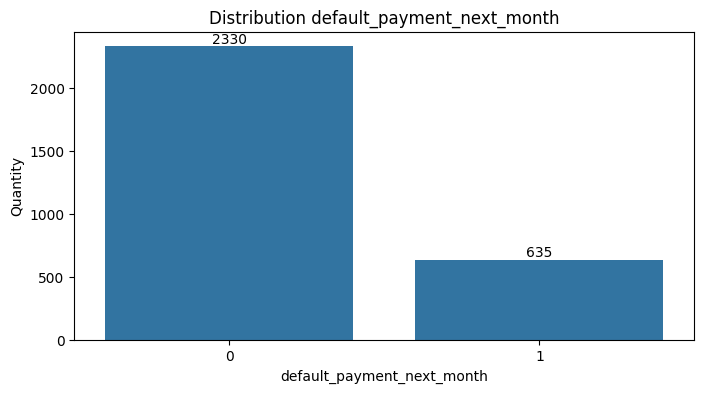

In [9]:
# menampilkan grafik 
plt.figure(figsize = (8,4))
ax = sns.countplot(x = df_1["default_payment_next_month"])
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution default_payment_next_month")
plt.ylabel("Quantity")
plt.show()

Dari diagram terlihat bahwa pengguna kartu kredit yang melakukan pembayaran lebih banyak dari pada yang gagal bayar.

C:\Users\MASTER\AppData\Local\Temp\ipykernel_22804\2140001804.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_1["sex"], palette="muted")


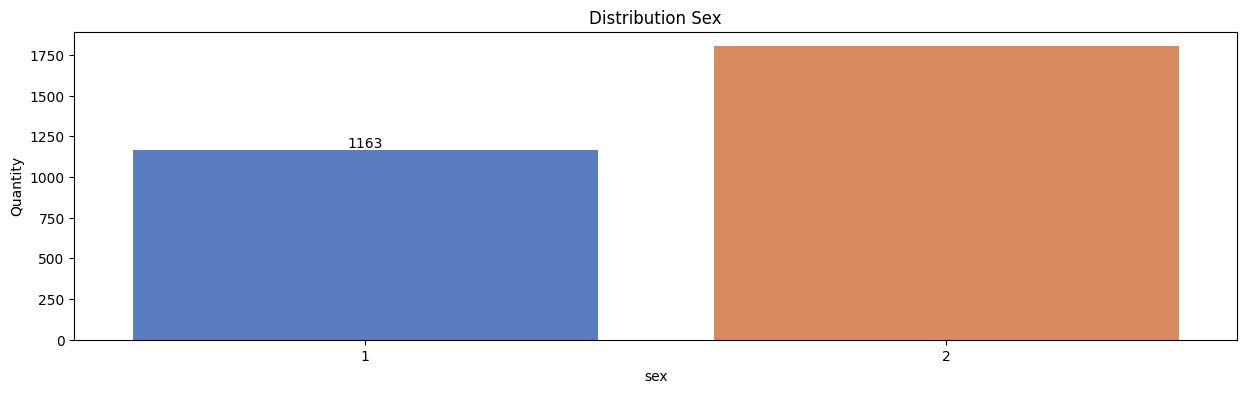

In [10]:
# menampilkan grafik 

plt.figure(figsize = (15,4))
ax = sns.countplot(x = df_1["sex"], palette="muted")
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution Sex")
plt.ylabel("Quantity")
plt.show()

Dari diagram terlihat pengguna kartu kredit adalah pria

C:\Users\MASTER\AppData\Local\Temp\ipykernel_22804\1017411352.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_1["marital_status"], palette="muted")


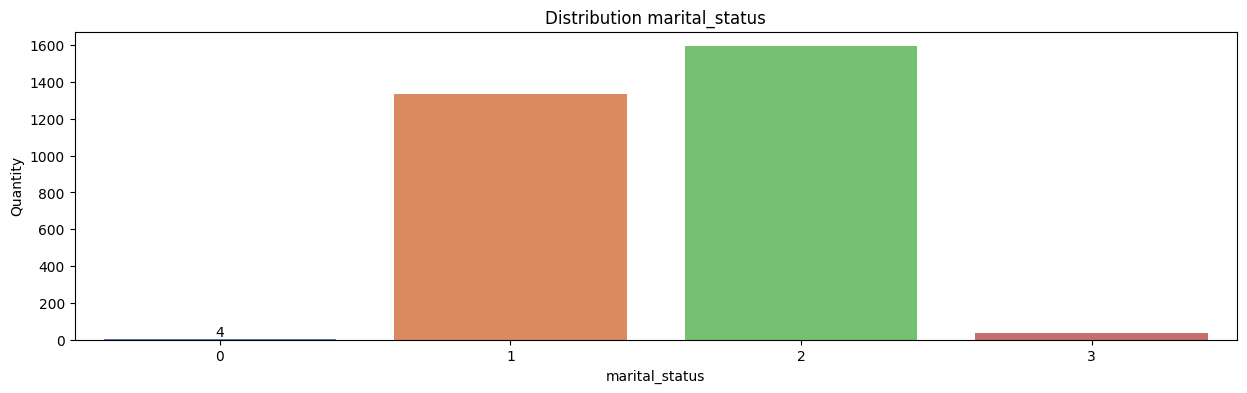

In [11]:
# menampilkan grafik 

plt.figure(figsize = (15,4))
ax = sns.countplot(x = df_1["marital_status"], palette="muted")
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution marital_status")
plt.ylabel("Quantity")
plt.show()

Dari diagram terlihat pengguna kartu kredit dengan status marriage adalah yang paling banyak.

C:\Users\MASTER\AppData\Local\Temp\ipykernel_22804\3678191287.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_1["education_level"], palette="muted")


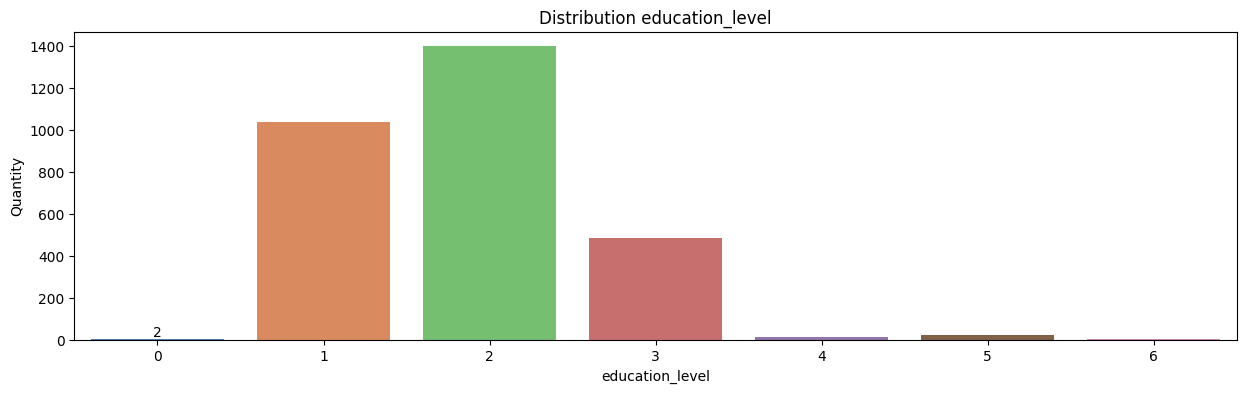

In [12]:
# menampilkan grafik 

plt.figure(figsize = (15,4))
ax = sns.countplot(x = df_1["education_level"], palette="muted")
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution education_level")
plt.ylabel("Quantity")
plt.show()

Dari diagram terlihat bahwa education level paling banyak adalah lulusan Universitas.

C:\Users\MASTER\AppData\Local\Temp\ipykernel_22804\2937818909.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_1["pay_0"], palette="muted")


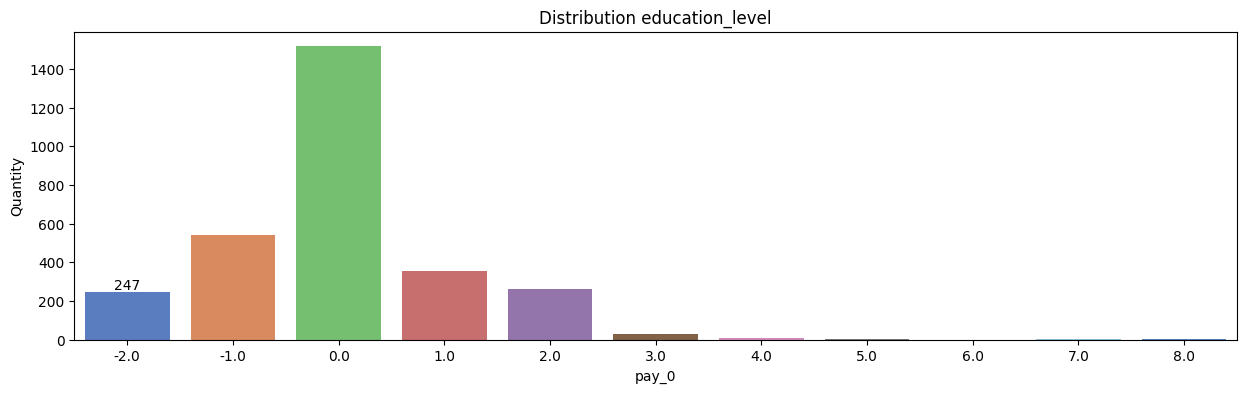

In [13]:
# menampilkan grafik 

plt.figure(figsize = (15,4))
ax = sns.countplot(x = df_1["pay_0"], palette="muted")
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution education_level")
plt.ylabel("Quantity")
plt.show()

Pada bulan September terlihat yang tidak memiliki tunggakan lebih mendominasi

C:\Users\MASTER\AppData\Local\Temp\ipykernel_22804\2844892442.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_1["pay_2"], palette="muted")


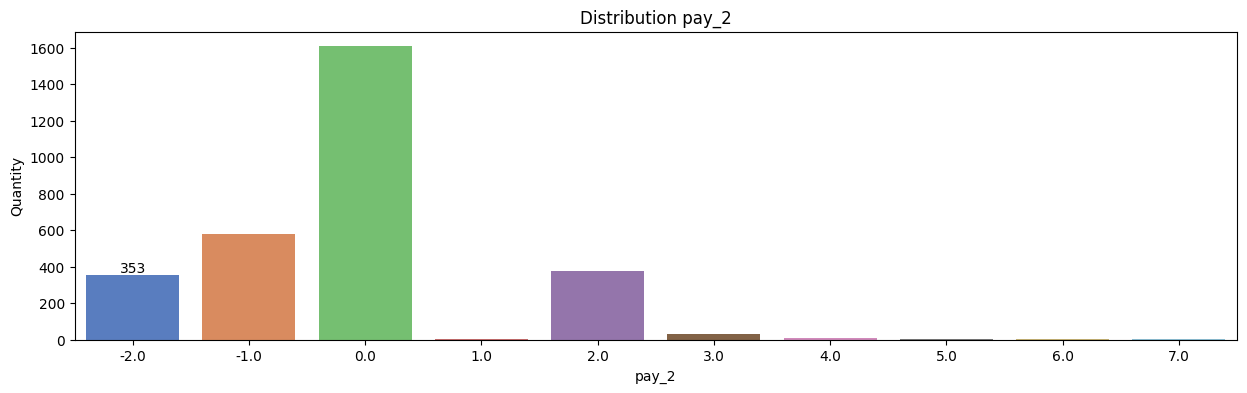

In [14]:
# menampilkan grafik 

plt.figure(figsize = (15,4))
ax = sns.countplot(x = df_1["pay_2"], palette="muted")
ax.bar_label(ax.containers[0], color = "black")
plt.title("Distribution pay_2")
plt.ylabel("Quantity")
plt.show()

Pada bulan Agustus terlihat yang tidak memiliki tunggakan lebih mendominasi

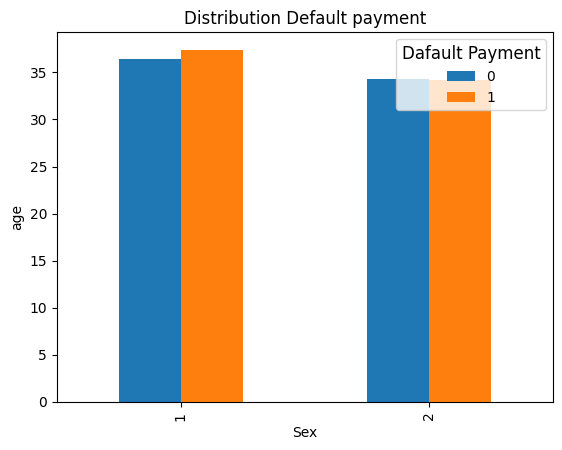

In [15]:
# Rumus grouping dalam satu kolom
grouped_data = df_1.groupby(['sex', 'default_payment_next_month'])['age'].mean()

# Membuat diagram batang (bar chart)
grouped_data.unstack().plot(kind='bar')
plt.title('Distribution Default payment')
plt.xlabel('Sex')
plt.ylabel('age')
plt.legend(title='Dafault Payment', title_fontsize='12', loc='upper right')
plt.show()

terlihat bahwa pria mendominasi sebagai pengguna kartu kredit dan yang lebih mendominasi gagal bayar adalah pria.

Insight yang dapat di ambil dari proses EDA ini adalah :
- Terlihat deafault payment di dominasi dengan 0 yang artinya yang membayar lebih banyak dari pada yang gagal bayar.
- Dari diagram terlihat bahwa pengguna kartu yang melakukan pembayaran lebih banyak dari pada yang gagal bayar.
- Dari diagram terlihat yang paling banyak pengguna kartu kredit adalah pria.
- Dari diagram terlihat pengguna kartu kredit dengan status marriage dalah yang paling banyak.
- Dari diagram terlihat bahwa edicatuion lovel paling banyak adalah lulusan Universitas.

# vi. Feature Engineering

### a. Data Spliting

### a.1 Membuat sample data inference

In [16]:
# menyimpan 1 data acak dari data asli untuk dijadikan inferensi data ke dalam variabel data_inf
data_inf = df_1.sample(1, random_state=40)

# hapus inferensi data dari df
df_1.drop(data_inf.index, inplace=True)

# reset indeks untuk data_inf dan df
df_1.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

data_inf.to_csv('data_inf.csv',index=False)

Sampel data ini kita ambil satu baris dari seluruh data untuk kemudian dijadikan sebagai bahan prediksi.

### a.2 Split between X (Faeture/Variables) and y (Target)

memisahkan antara target dan variablel

In [17]:
# Pisahkan antara 'X' dan 'y'
X = df_1.drop(['default_payment_next_month'],axis=1)
y = df_1.default_payment_next_month
X.shape

(2964, 23)

Variable (X) ini berisi
- 'limit_balance', 
- 'sex', 
- 'education_level', 
- 'marital_status', '
- 'age',
- 'pay_0',
- 'pay_2',
- 'pay_3',
- 'pay_4', 
- 'pay_5', 
- 'pay_6', 
- 'bill_amt_1',
- 'bill_amt_2',
- 'bill_amt_3', 
- 'bill_amt_4', 
- 'bill_amt_5', 
- 'bill_amt_6',
- 'pay_amt_1', 
- 'pay_amt_2', 
- 'pay_amt_3', 
- 'pay_amt_4', 
- 'pay_amt_5',
- 'pay_amt_6', 

Data target (y) adalah kolom 'default_payment_next_month', kita akan menggunakan label ini sebagai target saat membangun model dalam melakukan analisis lebih lanjut.


### a.3 Split between Train-set and Test-set

In [18]:
# Memisahkan antara Train dan Tet menggunakan 'train_test_split()'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)     #test size 0.2 artinya 20% biasanya digunakan 0,2-0.25dari seluruh data #random state harus di isi dengan nilai agar tidak berubah2 boleh dengan angka apapun

print('Train Size :', X_train.shape)
print('Test Size :', X_test.shape)
X_train.head()

Train Size : (2223, 23)
Test Size : (741, 23)


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
828,30000.0,2,2,2,23.0,0.0,0.0,0.0,0.0,0.0,...,26985.0,29497.0,29290.0,28693.0,10000.0,5000.0,3000.0,2000.0,3150.0,0.0
11,780000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,190663.0,195124.0,184872.0,191090.0,10000.0,15004.0,10000.0,8000.0,10028.0,7003.0
1693,150000.0,1,1,1,29.0,-1.0,-1.0,-1.0,0.0,0.0,...,90787.0,11232.0,0.0,0.0,20995.0,91269.0,56.0,0.0,0.0,0.0
2909,100000.0,1,3,2,49.0,-1.0,-1.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2745,20000.0,2,2,2,21.0,-1.0,-1.0,2.0,2.0,-2.0,...,780.0,0.0,0.0,0.0,780.0,0.0,0.0,0.0,0.0,0.0


Setelah dilakukan hasil Train Size adalah (2223, 23), dan Test Size = (741, 23)

### b. Missing Value Handling

Pada tahap ini kita cek apakah ada missing value jika ada handling jika ternyata tidak ada lanjutkan ke proses selanjutnya.

In [19]:
# Memeriksa nilai yang hilang dalam setiap kolom
missing_values = df_1.isnull().sum()

# Menampilkan jumlah nilai yang hilang dalam setiap kolom
missing_values

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Data lengkap tidak ada missing value.

In [20]:
# Tampilkan duplikat data
df_1.duplicated().sum()

1

Terdapat satu duplikat dan kita akan menghapusnya. 

In [21]:
# hapus data duplikat
df_1 = df_1.drop_duplicates()

Penghapusan data duplikat berhasil di lakukan.

In [22]:
# Tampilkan duplikat data
df_1.duplicated().sum()

0

sudah tidak ada data duplikat

### C. Outlier Handling

Pada bagian ini kita melakukan proses outlier handling dengan tahapan :
- Menentukan data distribusi normal atau tidak
- Menampilkan distribusi melalui diagram
- Memastikan nilai upper bounder dan lower bounder
- Handling fitur yang memiliki outlier

#### a. Cek Distribusi

Disisni akan kita cari tau mana kolom dengan distribusi normal dan skew.

In [23]:
#buat data frame baru yang berisi kolom numerical
numerical = ['limit_balance', 'age','bill_amt_1','bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6']

# categorical = ['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for i in numerical:
     print(f'Distribution of column  {[i]}          : ', X_train[i].skew())

Distribution of column  ['limit_balance']          :  0.9708561574189163
Distribution of column  ['age']          :  0.7476424877947022
Distribution of column  ['bill_amt_1']          :  2.399298521405412
Distribution of column  ['bill_amt_2']          :  2.356734982475207
Distribution of column  ['bill_amt_3']          :  2.5390768776694905
Distribution of column  ['bill_amt_4']          :  2.408962165006307
Distribution of column  ['bill_amt_5']          :  2.314503726278179
Distribution of column  ['bill_amt_6']          :  2.352001169002178
Distribution of column  ['pay_amt_1']          :  11.53469753951217
Distribution of column  ['pay_amt_2']          :  32.39400164410013
Distribution of column  ['pay_amt_3']          :  8.045082335912905
Distribution of column  ['pay_amt_4']          :  8.819722977834145
Distribution of column  ['pay_amt_5']          :  10.533492477973216
Distribution of column  ['pay_amt_6']          :  10.737706536919582


Derlihat bahwa seluruh data merupakan extream skew.

### b. Menampilkan Diagram Distribusi

In [24]:

def diagnostic_plots(df_1, variable):
    # Tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_1[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_1[variable])
    plt.title('Boxplot')


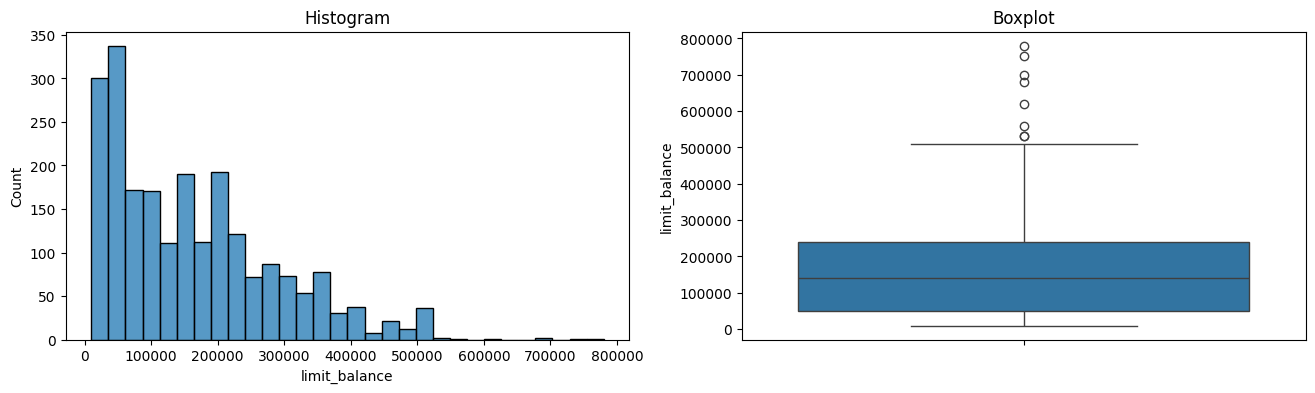

In [25]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'limit_balance')

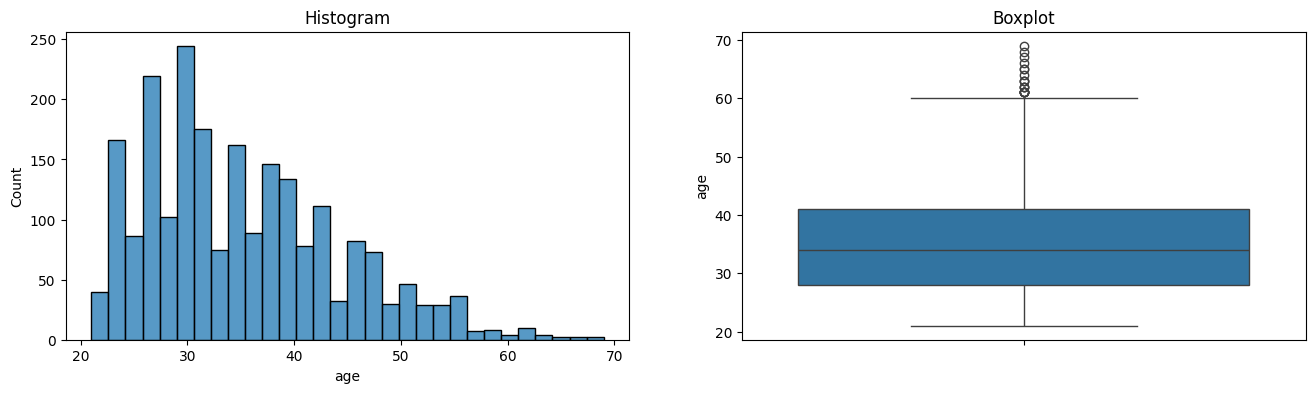

In [26]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'age')

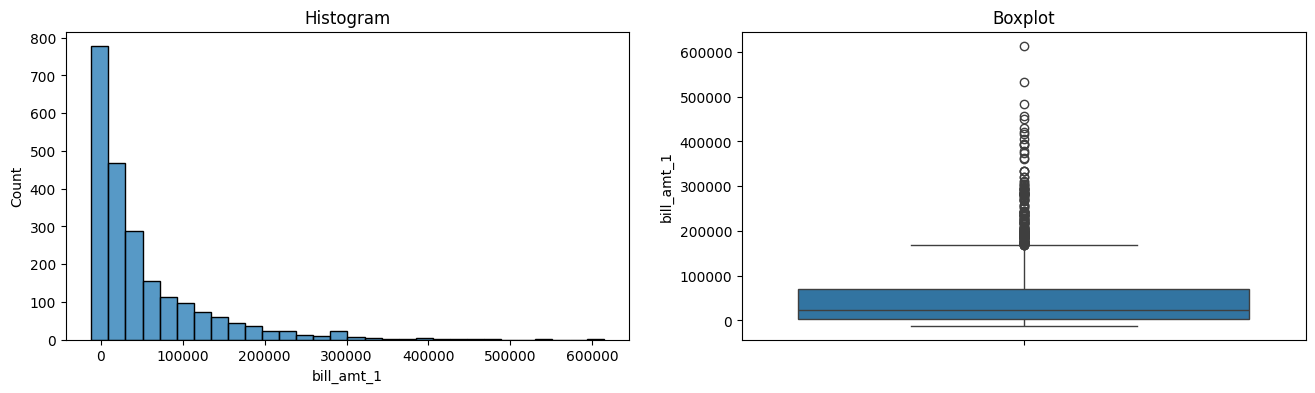

In [27]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_1')

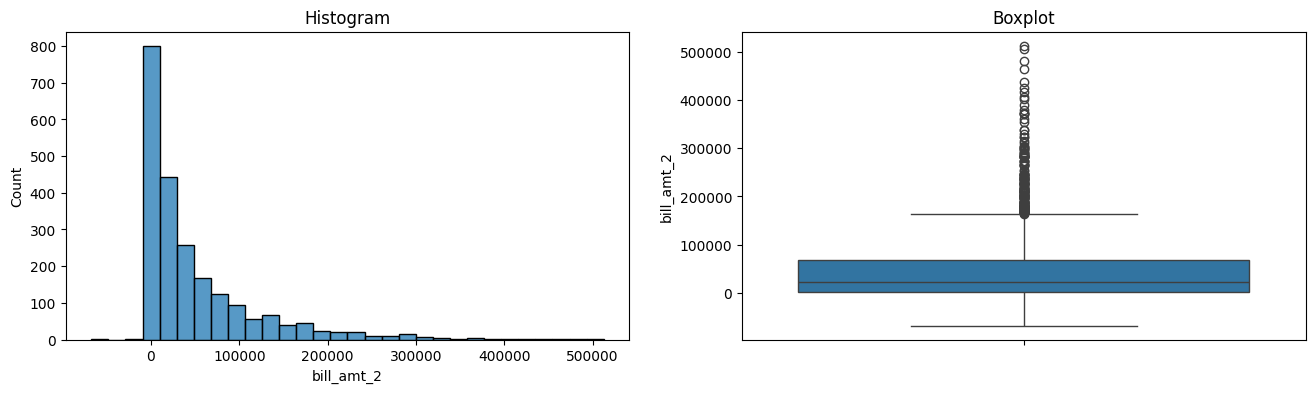

In [28]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_2')

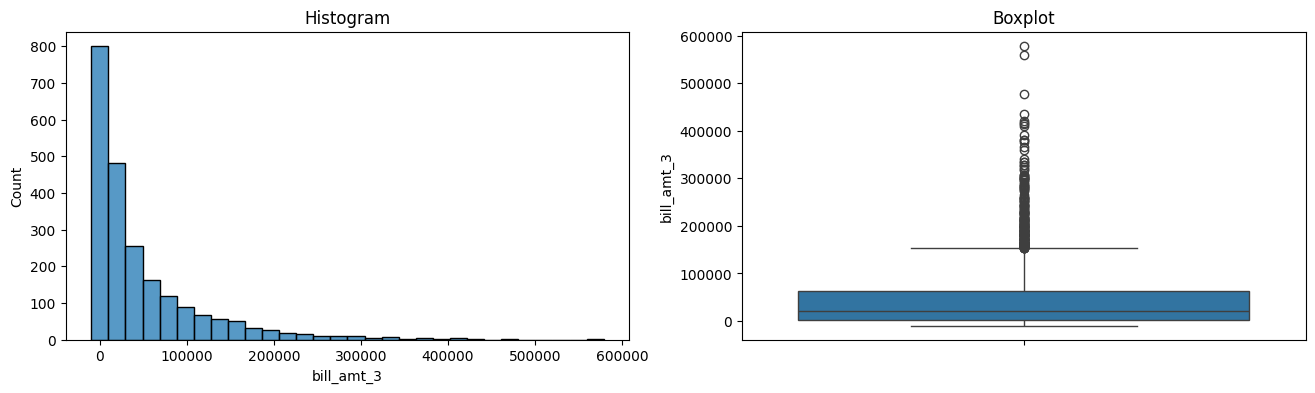

In [29]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_3')

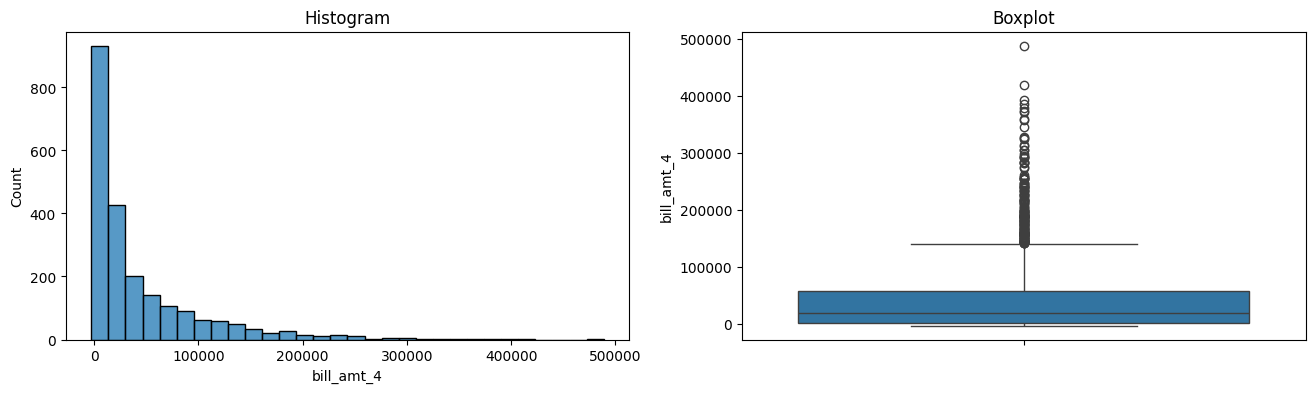

In [30]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_4')

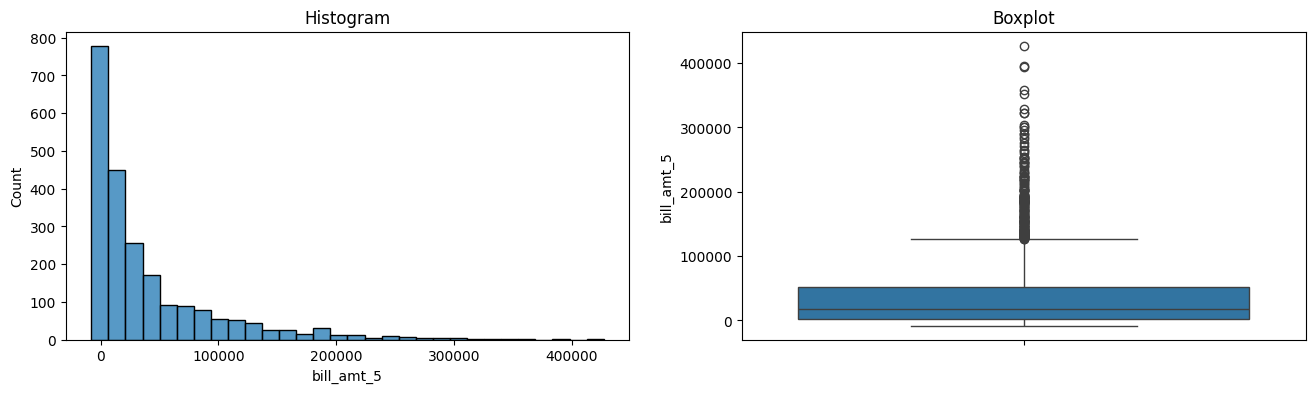

In [31]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_5')

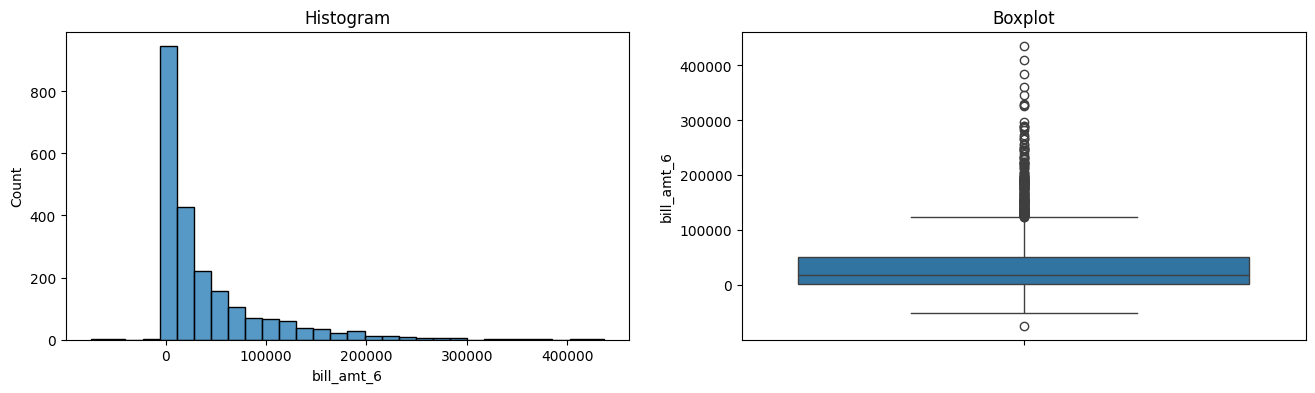

In [32]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'bill_amt_6')

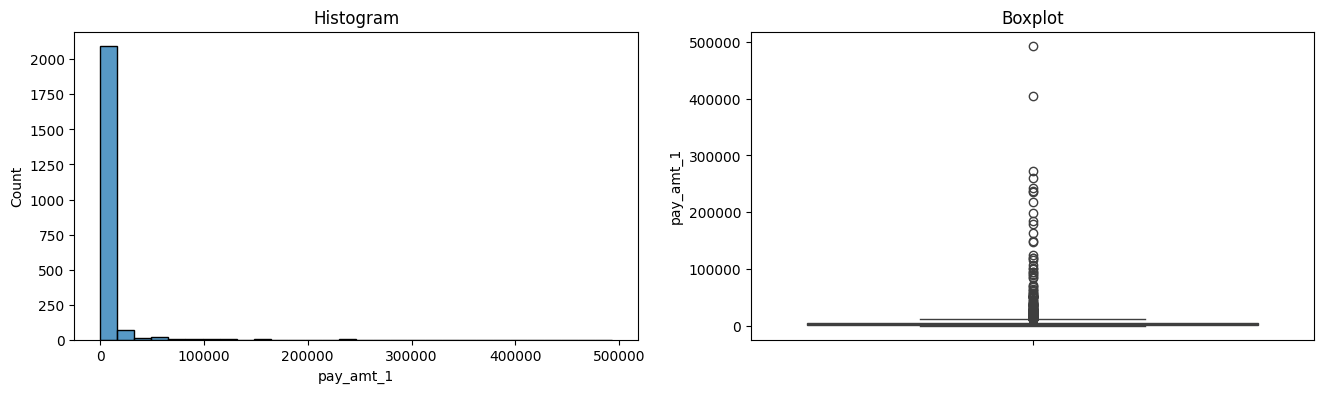

In [33]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_1')

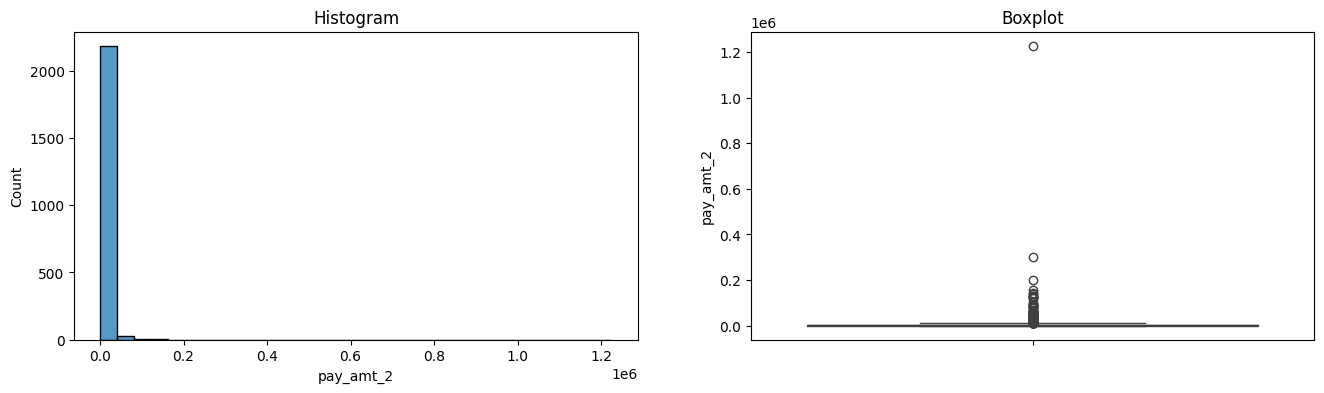

In [34]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_2')

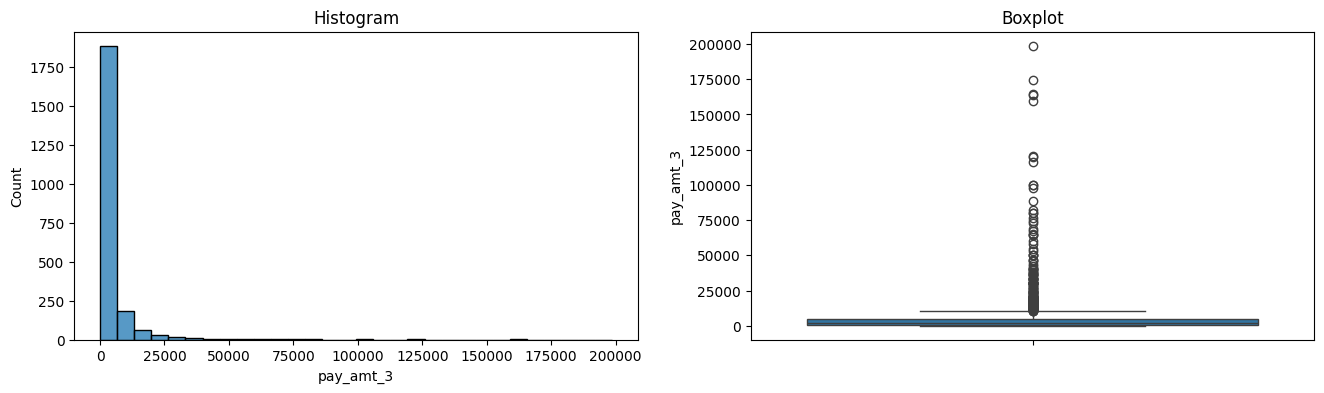

In [35]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_3')

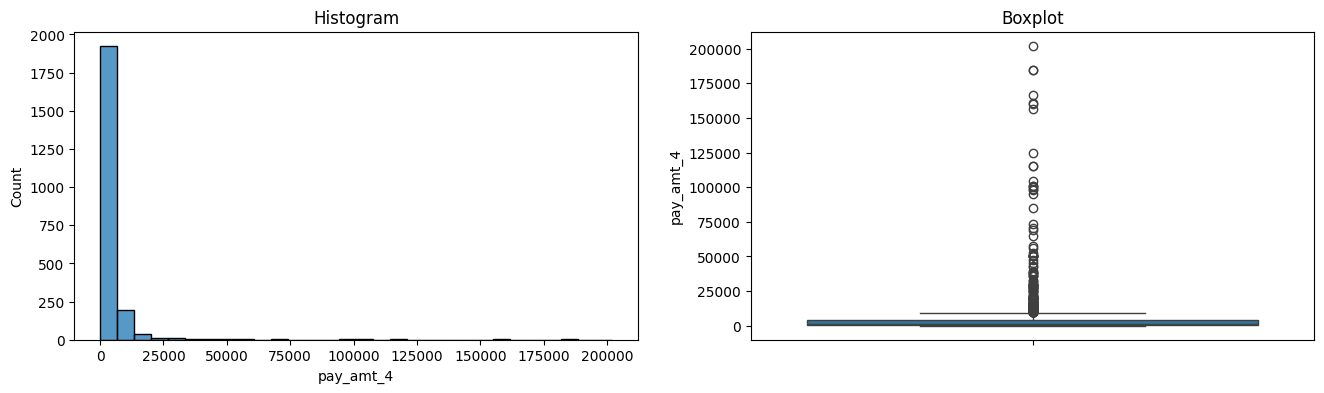

In [36]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_4')

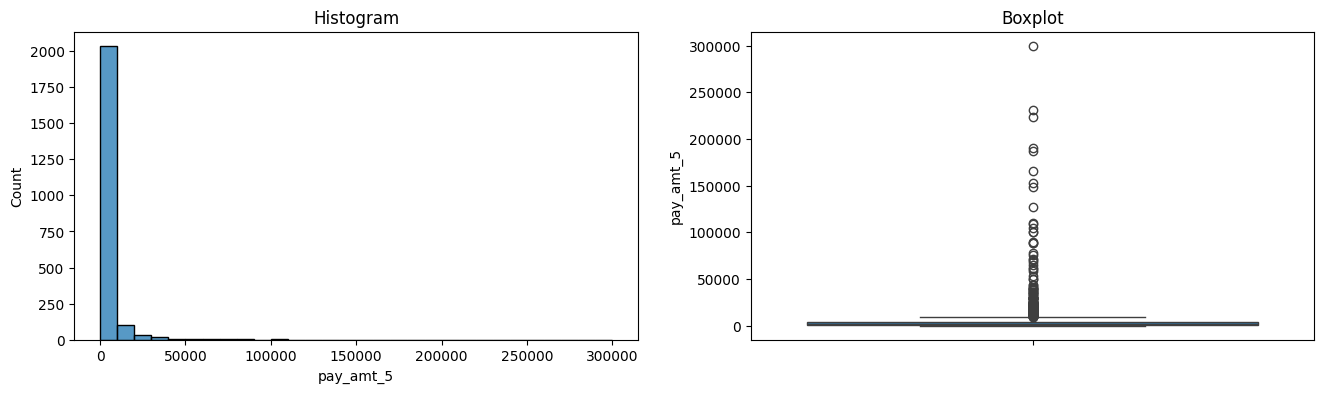

In [37]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_5')

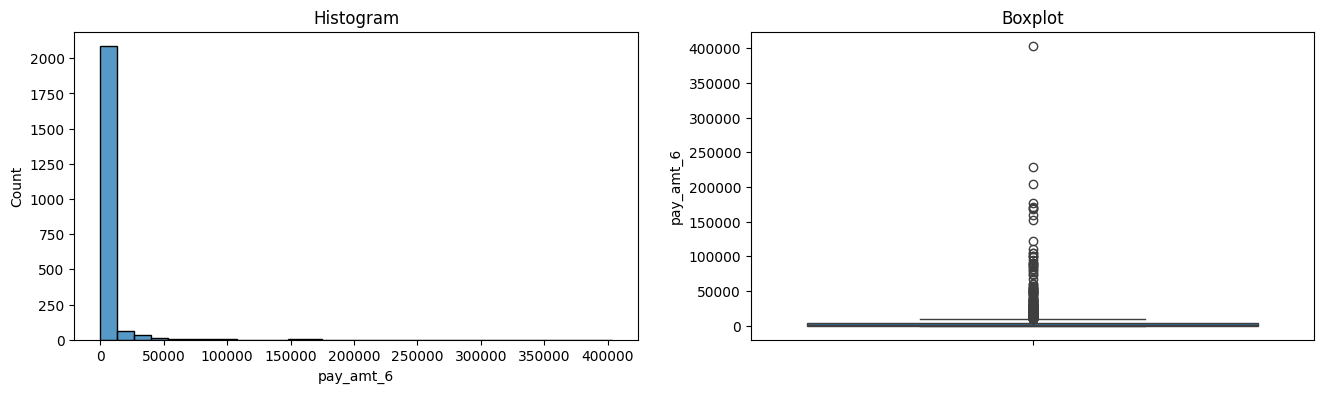

In [38]:
# visualisasi skewed distribution menggunakan boxplot
diagnostic_plots(X_train, 'pay_amt_6')

Dapat dilihat dari diagram bahwa kolom `limit_balance`,`age`,`bill_amt_1`, `bill_amt_2`, `bill_amt_3`, `bill_amt_4`, `bill_amt_5`, `bill_amt_6`, `pay_amt_1`, `pay_amt_2`, `pay_amt_3`, `pay_amt_4`, `pay_amt_5`, dan `pay_amt_6`terdapat distribusi skew.

#### c. Memastikan nilai upper bounder dan lower bounder

Memastikan nilai upper bound dan lower bound penting untuk menjaga validitas data, menghindari kesalahan perhitungan, dan mematuhi batasan yang ada dalam konteks tertentu. dalam hal ini memeriksa apakah data sudah di antara upper bounder atau belum.

In [39]:
# Berfungsi untuk mencari batas atas dan bawah variabel yang terdistribusi normal
def find_normal_boundaries(df_1, variable):
    # Hitung batas luar yang merupakan outlier untuk distribusi Gaussian
    upper_boundary = df_1[variable].mean() + 3 * df_1[variable].std()
    lower_boundary = df_1[variable].mean() - 3 * df_1[variable].std()

    return upper_boundary, lower_boundary

In [40]:
numeric_data = ['limit_balance', 'age', 'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5',
                'bill_amt_6', 'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4',
                 'pay_amt_5','pay_amt_6' ]

for i in numeric_data:
    # Kita hitung batas luar yang merupakan outlier untuk distribusi yang miring
    IQR = X_train[i].quantile(0.75) - X_train[i].quantile(0.25)
    # Jarak yang dilewati sebagai argumen, memberi kita pilihan untuk memperkirakan 1,5 kali atau 3 kali IQR untuk menghitung batasannya.
    lower_boundary_distance = X_train[i].quantile(0.25) - (IQR * 1.5)
    upper_boundary_distance = X_train[i].quantile(0.75) + (IQR * 1.5)

    print(f'upper boundary for {[i]} : {upper_boundary_distance}')
    print(f'lower boundary for {[i]} : {lower_boundary_distance}')
    print("---------------------------------------------------------")

upper boundary for ['limit_balance'] : 525000.0
lower boundary for ['limit_balance'] : -235000.0
---------------------------------------------------------
upper boundary for ['age'] : 60.5
lower boundary for ['age'] : 8.5
---------------------------------------------------------
upper boundary for ['bill_amt_1'] : 167655.0
lower boundary for ['bill_amt_1'] : -94645.0
---------------------------------------------------------
upper boundary for ['bill_amt_2'] : 164575.0
lower boundary for ['bill_amt_2'] : -93829.0
---------------------------------------------------------
upper boundary for ['bill_amt_3'] : 153398.25
lower boundary for ['bill_amt_3'] : -87499.75
---------------------------------------------------------
upper boundary for ['bill_amt_4'] : 141492.5
lower boundary for ['bill_amt_4'] : -81139.5
---------------------------------------------------------
upper boundary for ['bill_amt_5'] : 126292.25
lower boundary for ['bill_amt_5'] : -72753.75
----------------------------------

#### d Melakukan Capping

In [41]:
# Capping skewed distribution
numeric_data = ['limit_balance', 'age', 'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5',
                'bill_amt_6', 'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4',
                'pay_amt_5','pay_amt_6' ]

winsoriser_fare = Winsorizer(capping_method='quantiles',
                             tail='both',
                             fold=3,
                             variables=numeric_data)

X_train_capped = winsoriser_fare.fit_transform(X_train)
X_test_capped = winsoriser_fare.transform(X_test)

# show skewness
print(f"Before: {X_train[numeric_data].skew()}")
print(f"After: {X_train_capped[numeric_data].skew()}")

Before: limit_balance     0.970856
age               0.747642
bill_amt_1        2.399299
bill_amt_2        2.356735
bill_amt_3        2.539077
bill_amt_4        2.408962
bill_amt_5        2.314504
bill_amt_6        2.352001
pay_amt_1        11.534698
pay_amt_2        32.394002
pay_amt_3         8.045082
pay_amt_4         8.819723
pay_amt_5        10.533492
pay_amt_6        10.737707
dtype: float64
After: limit_balance    0.623364
age              0.498073
bill_amt_1       1.397702
bill_amt_2       1.427461
bill_amt_3       1.406524
bill_amt_4       1.428490
bill_amt_5       1.456309
bill_amt_6       1.440895
pay_amt_1        1.800786
pay_amt_2        1.886804
pay_amt_3        1.925262
pay_amt_4        1.530326
pay_amt_5        1.732445
pay_amt_6        2.064565
dtype: float64


- Data kolom limit_balance berhasil di capping
- saat menggunakan methode iqr handling data tidak berpengaruh hingga di ubah dengan menggunakan methode quantiles dengan penuruan yang lebih signifikan.

### e. Menampilkan diagram sebelum dan sesuah di capping

distance - Sebelum Capping

distance - Sesudah Capping


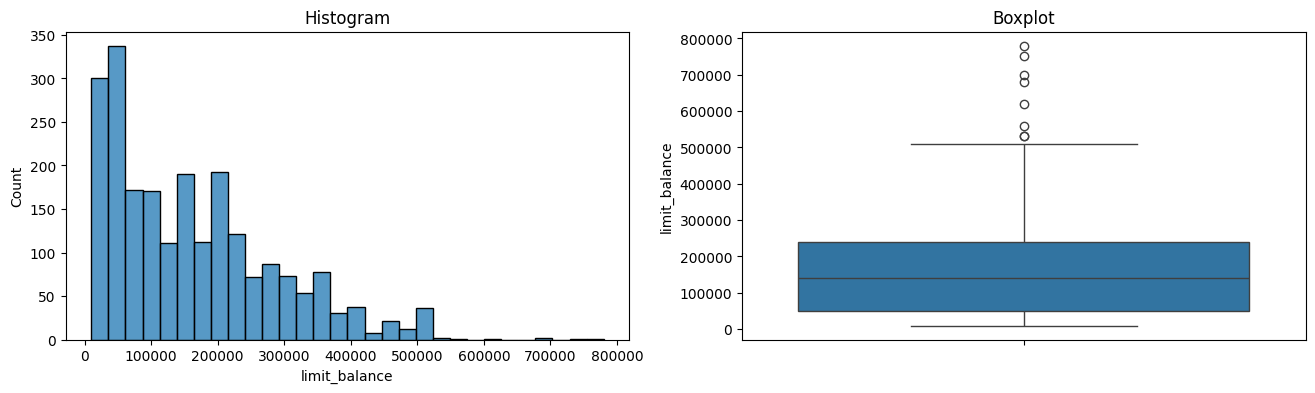

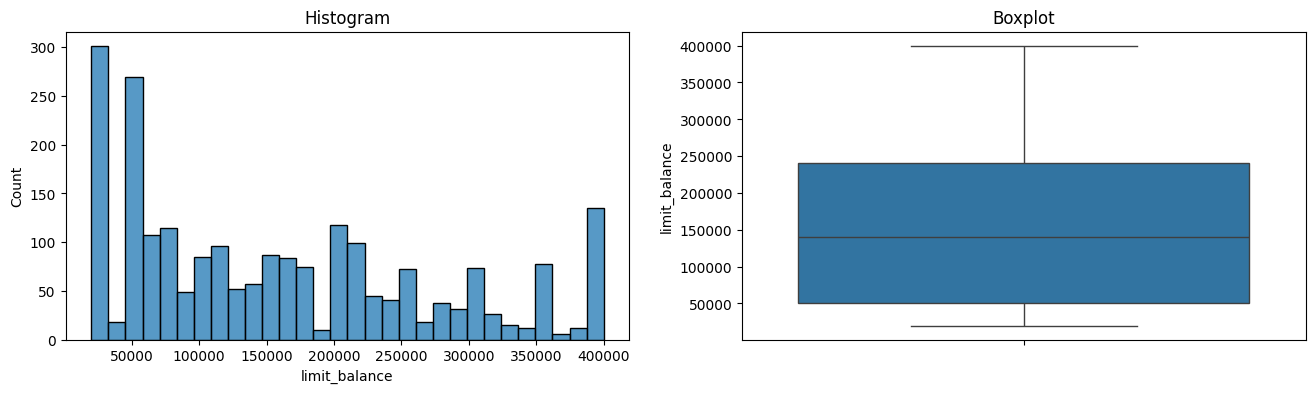

In [42]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'limit_balance')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'limit_balance')

distance - Sebelum Capping

distance - Sesudah Capping


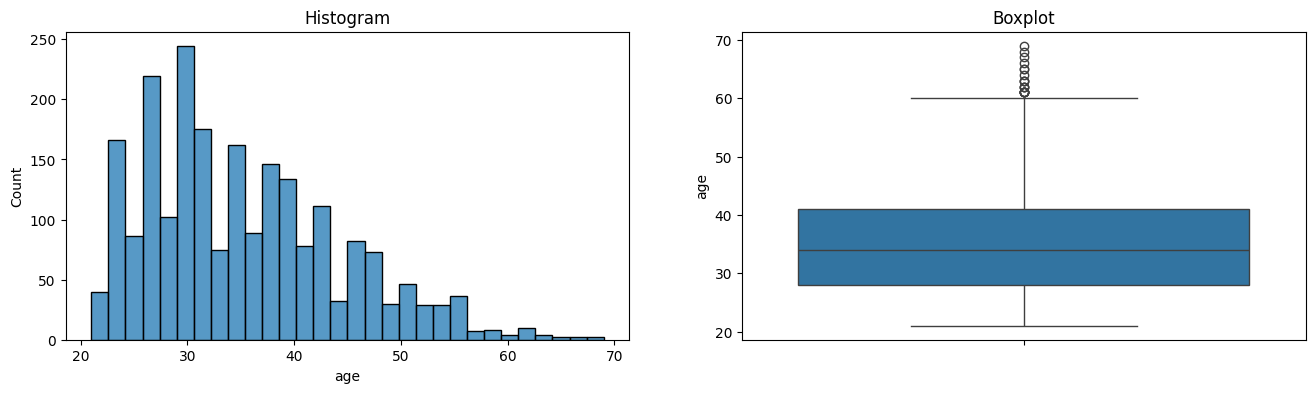

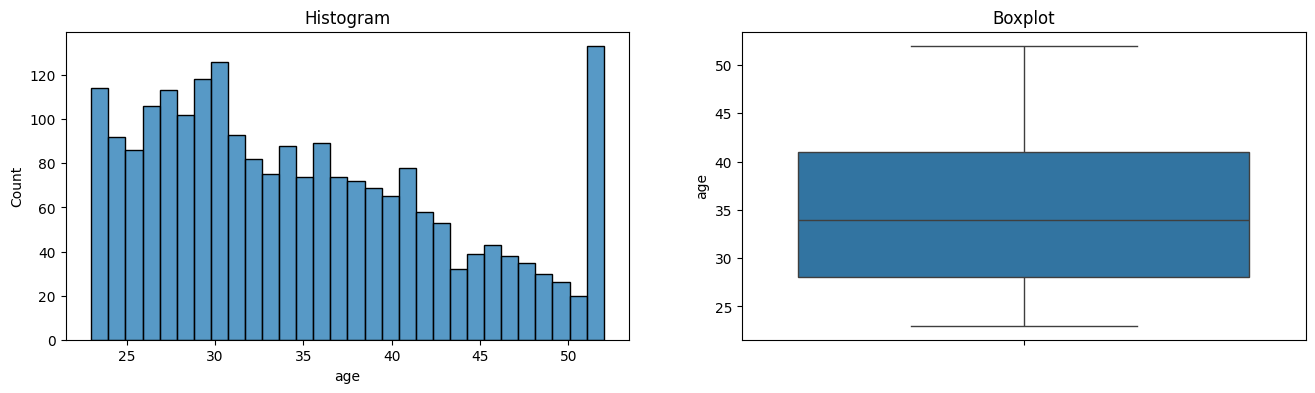

In [43]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'age')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'age')

distance - Sebelum Capping

distance - Sesudah Capping


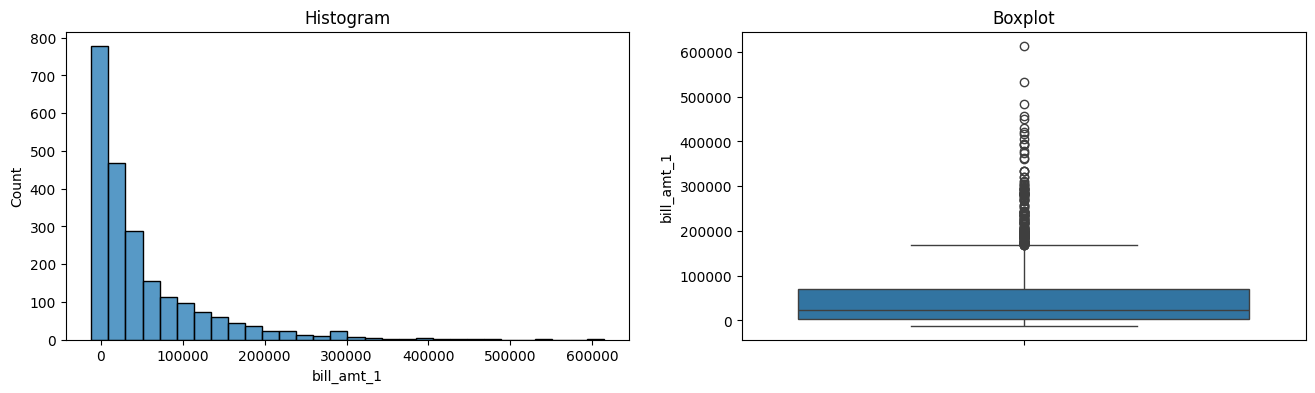

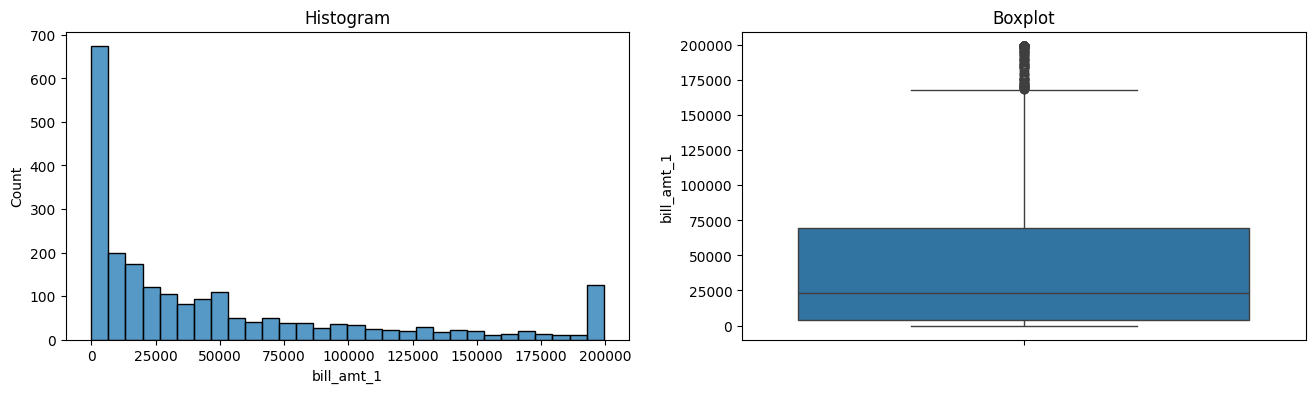

In [44]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_1')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_1')

distance - Sebelum Capping

distance - Sesudah Capping


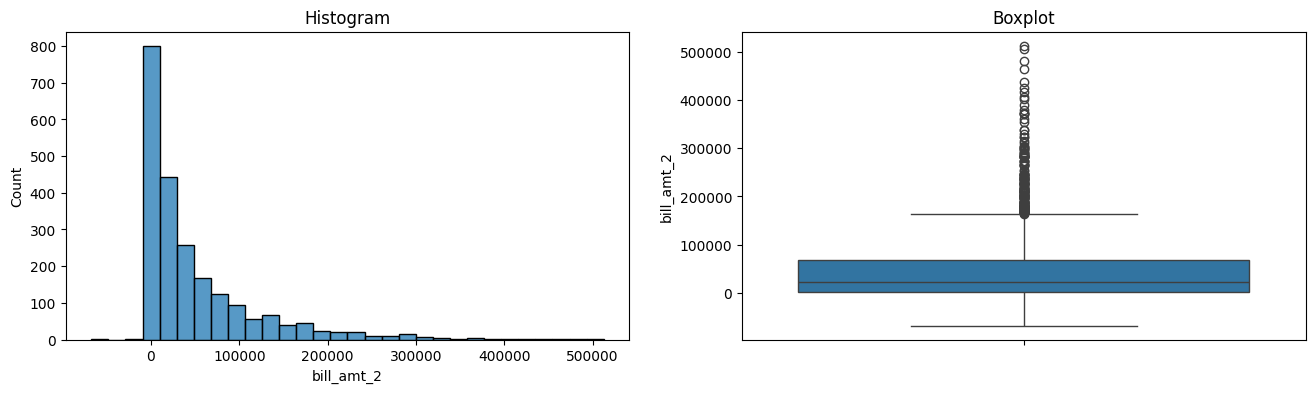

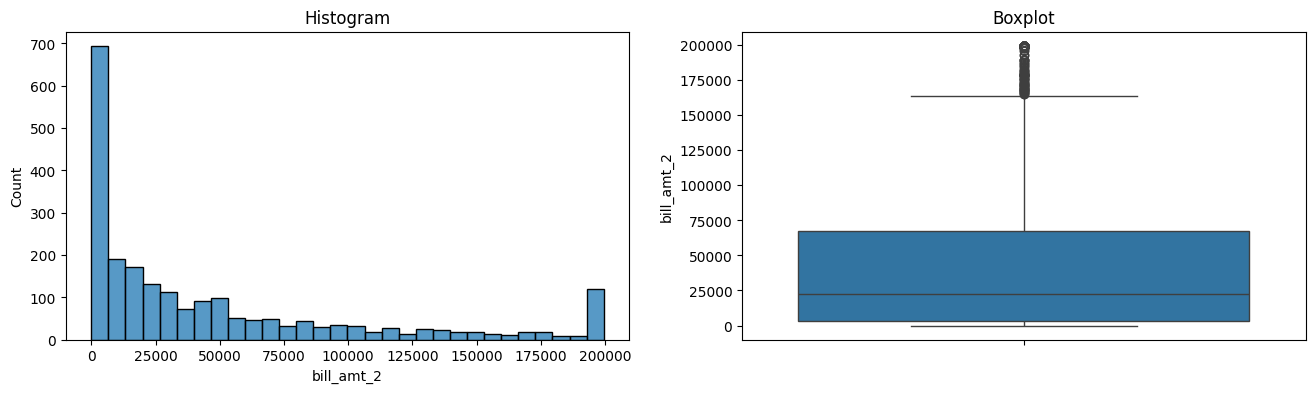

In [45]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_2')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_2')

distance - Sebelum Capping

distance - Sesudah Capping


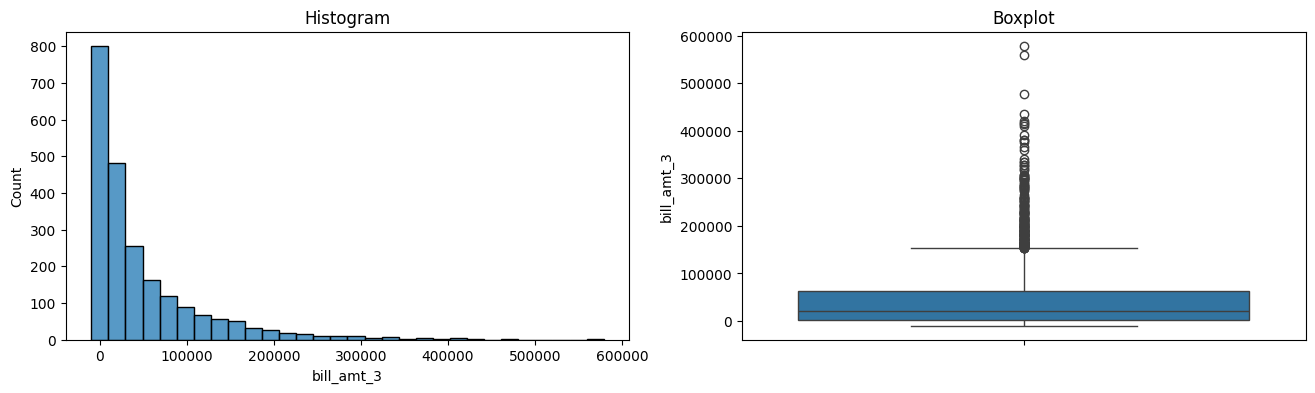

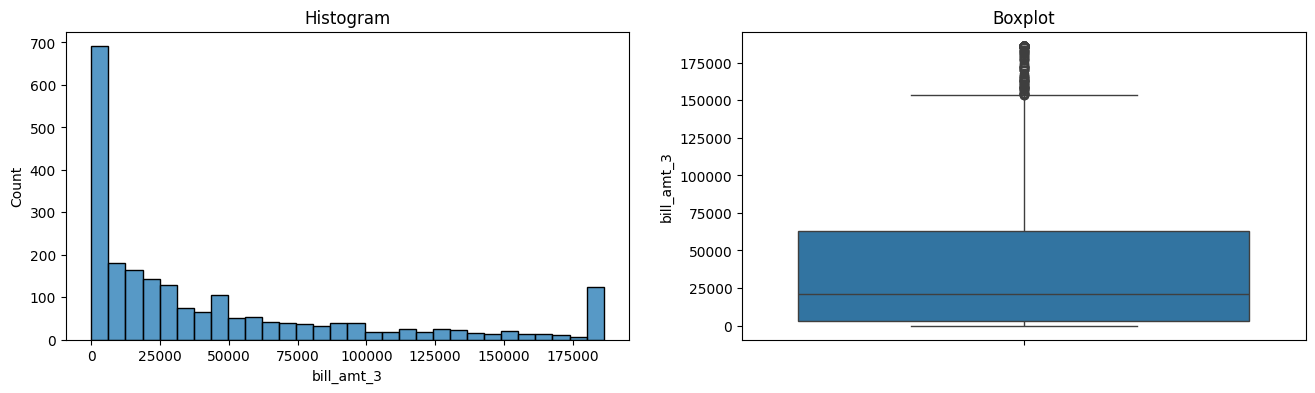

In [46]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_3')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_3')

distance - Sebelum Capping

distance - Sesudah Capping


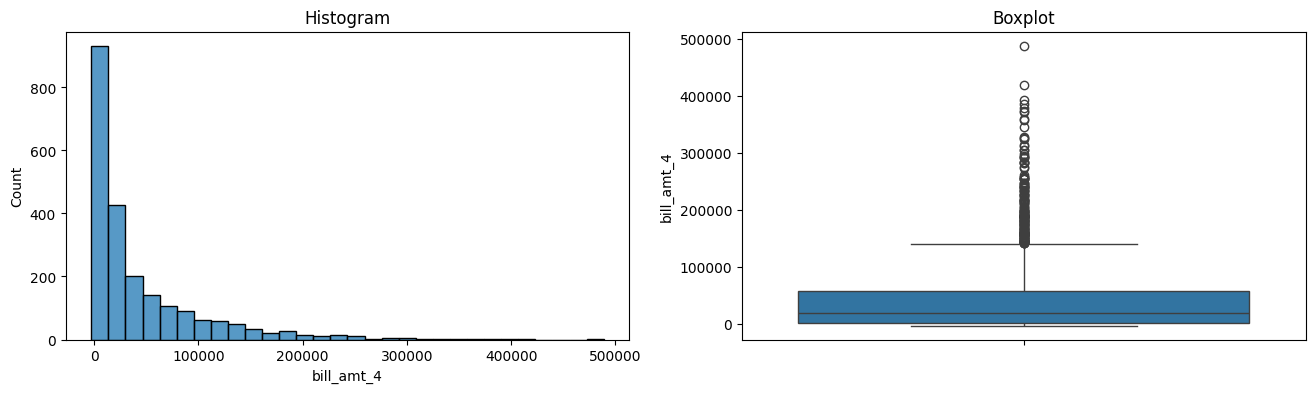

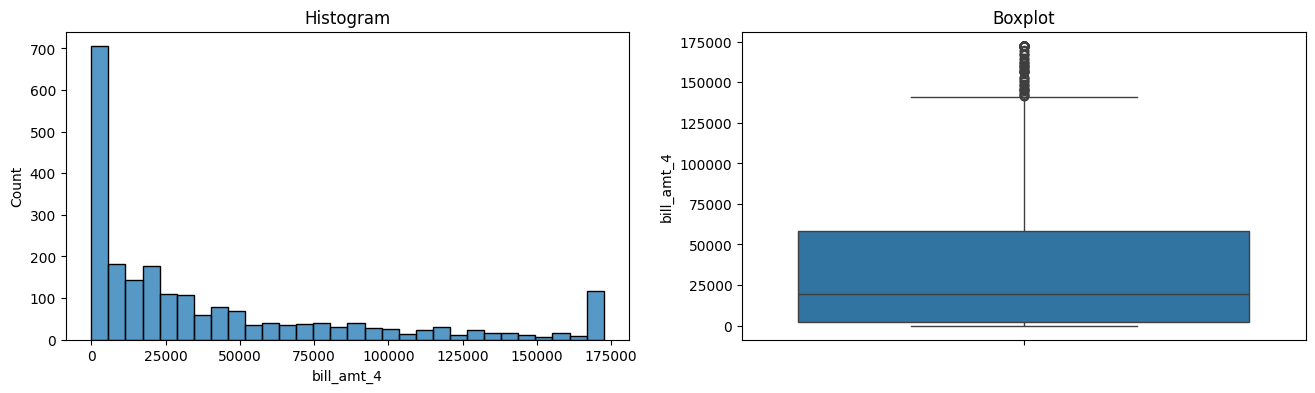

In [47]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_4')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_4')

distance - Sebelum Capping

distance - Sesudah Capping


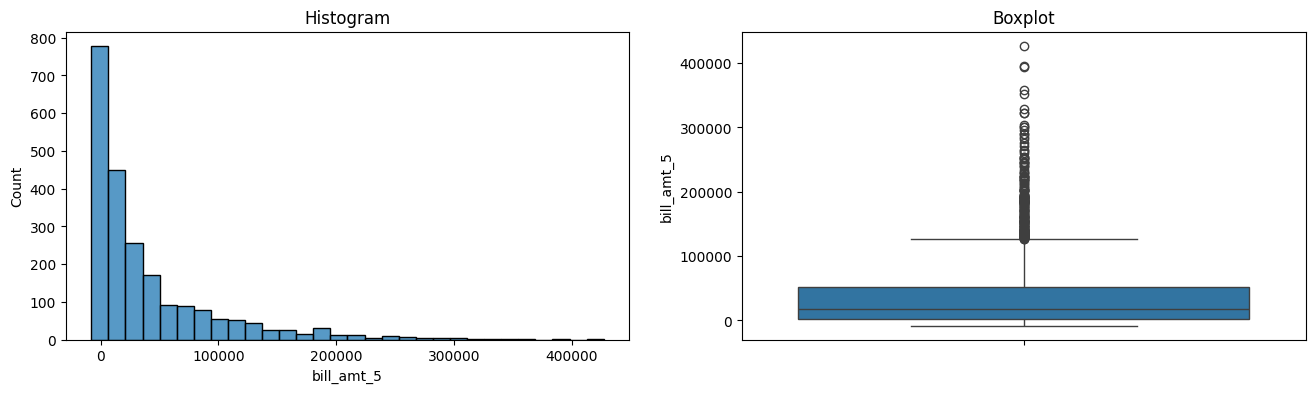

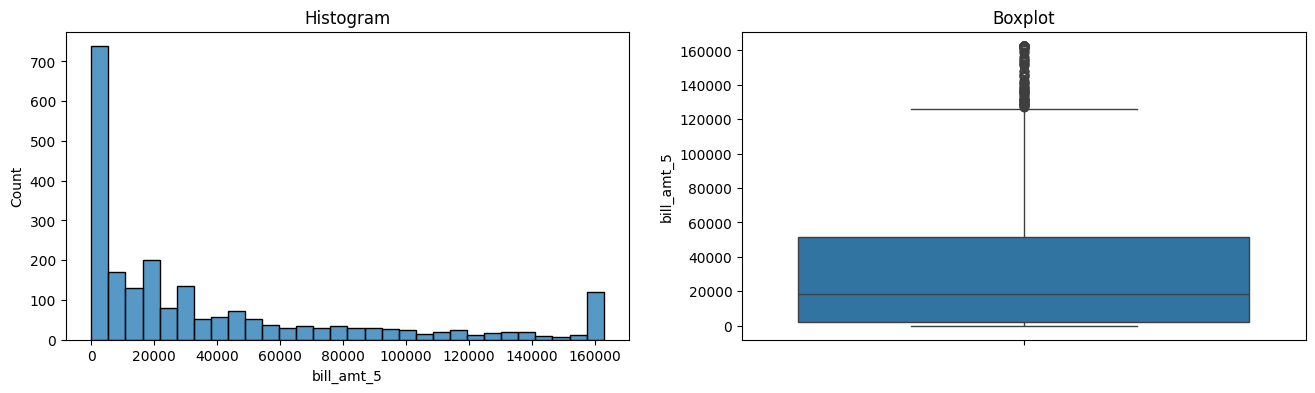

In [48]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_5')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_5')

distance - Sebelum Capping

distance - Sesudah Capping


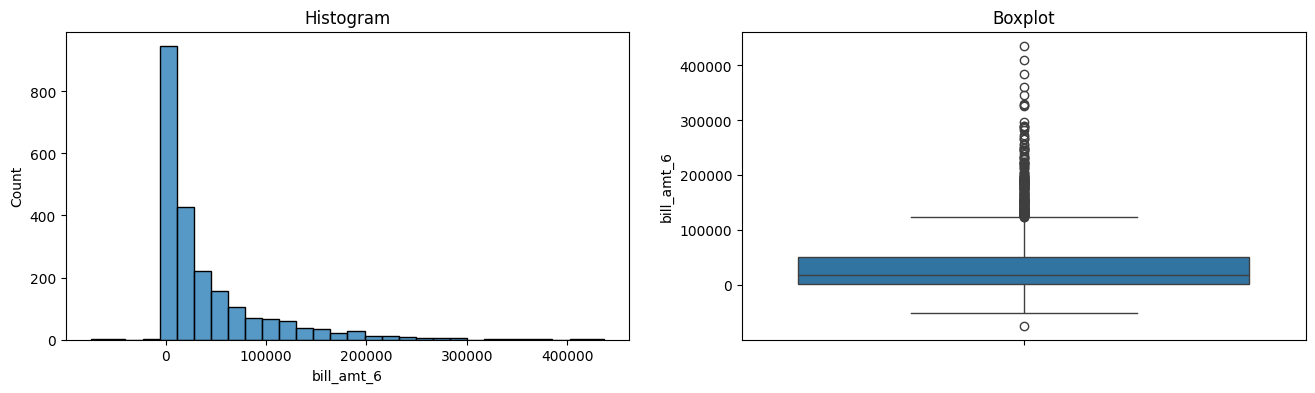

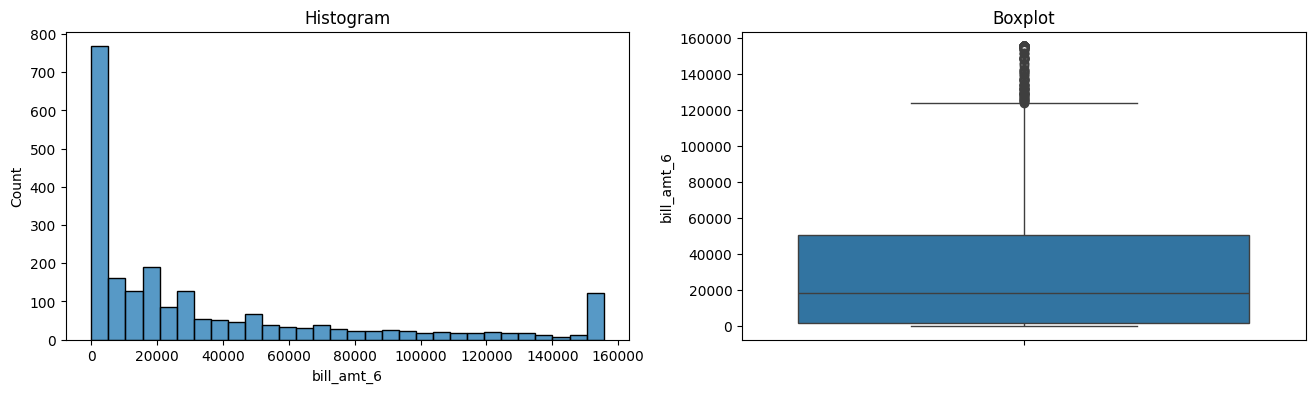

In [49]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'bill_amt_6')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'bill_amt_6')

distance - Sebelum Capping

distance - Sesudah Capping


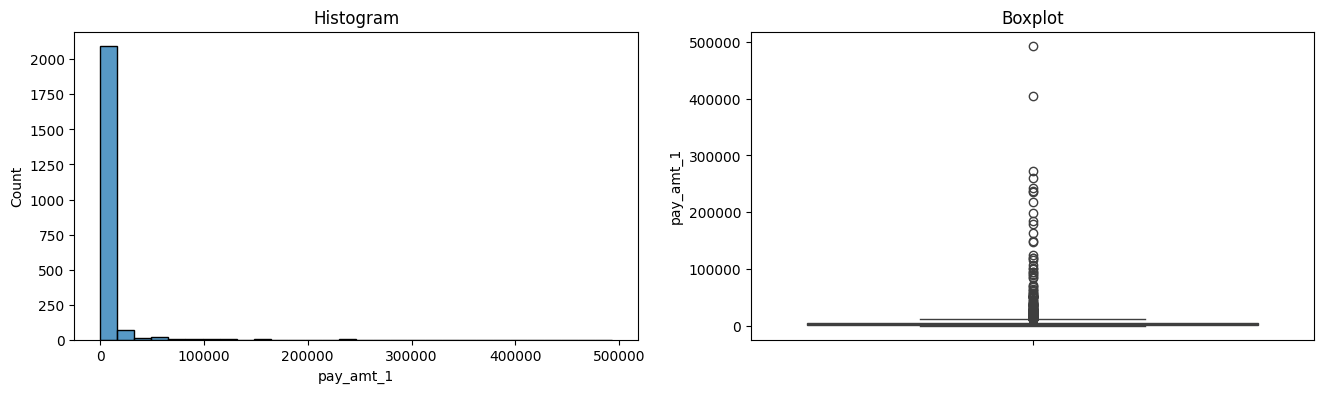

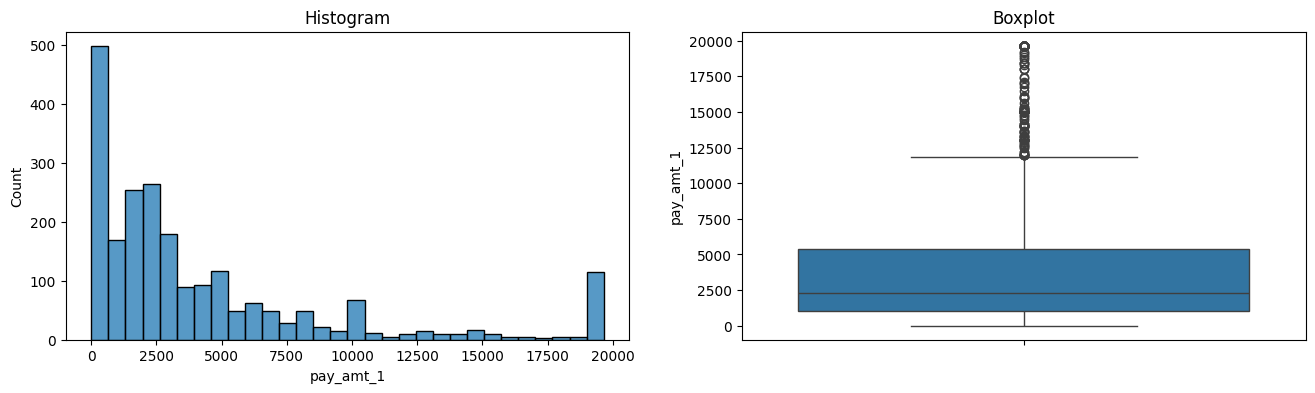

In [50]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_1')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_1')

distance - Sebelum Capping

distance - Sesudah Capping


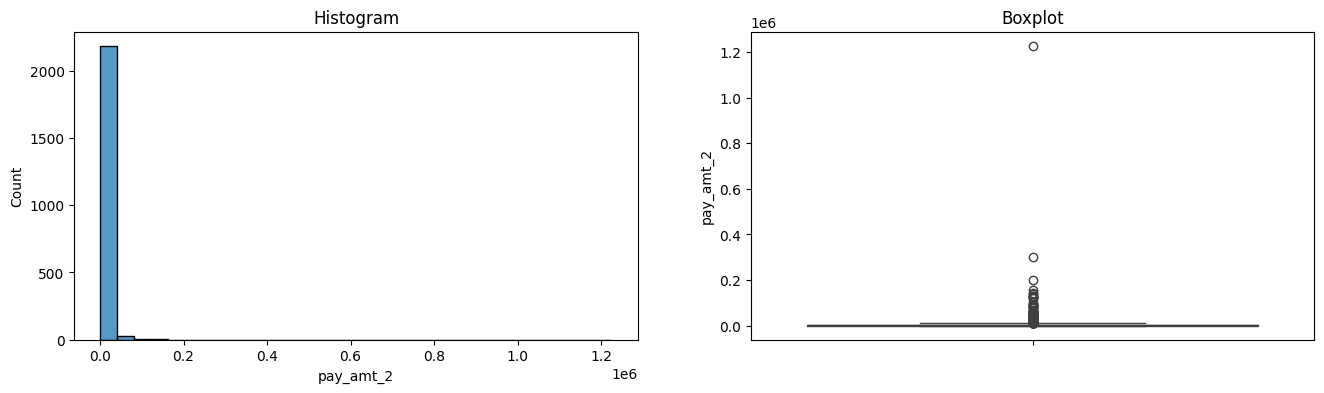

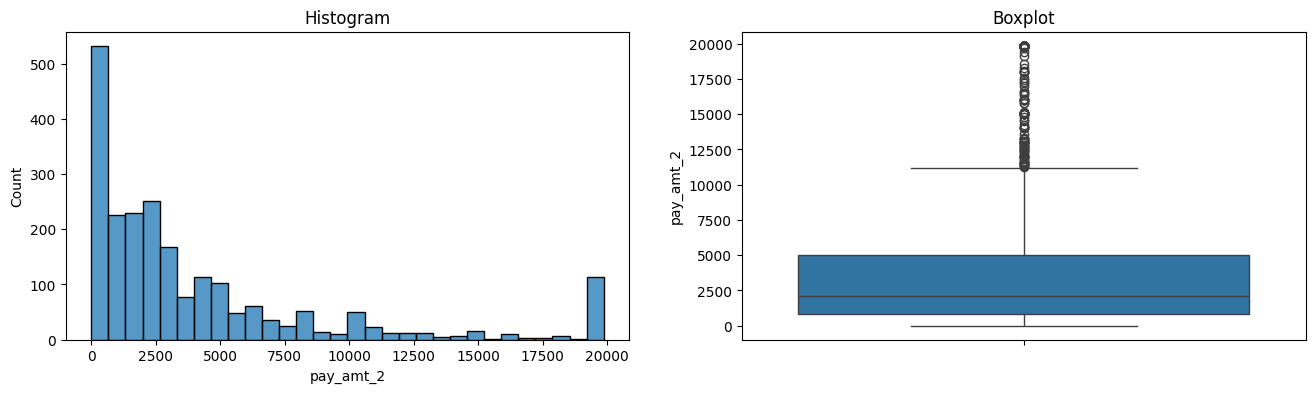

In [51]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_2')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_2')

distance - Sebelum Capping

distance - Sesudah Capping


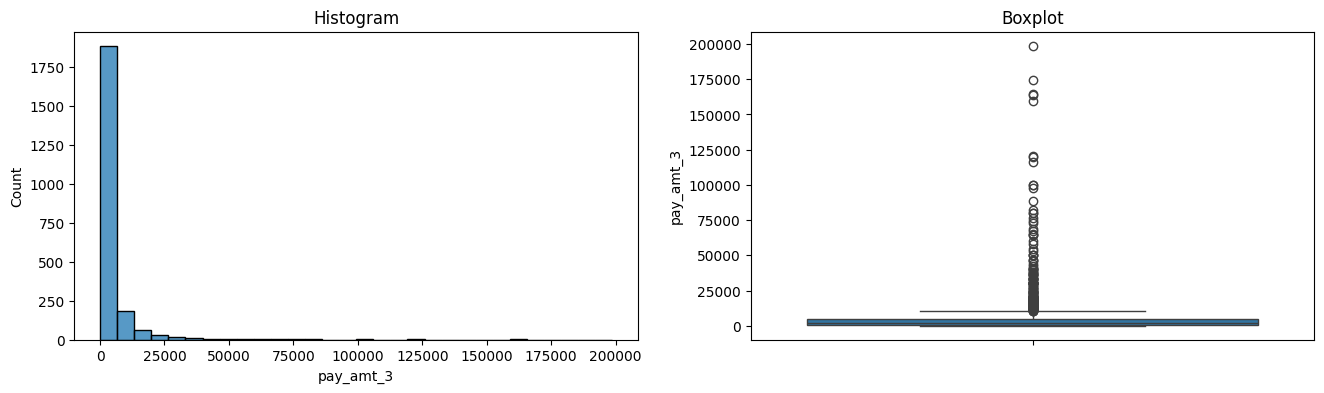

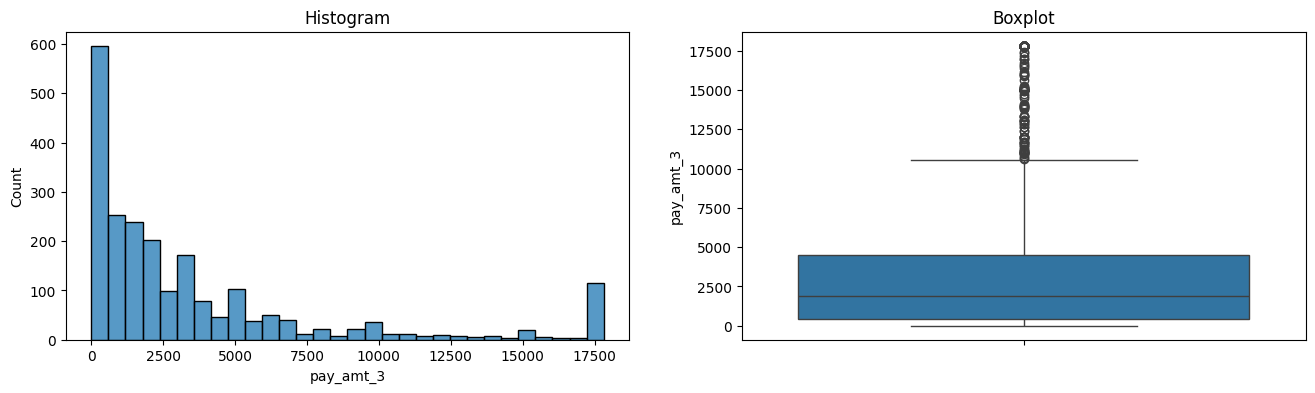

In [52]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_3')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_3')

distance - Sebelum Capping

distance - Sesudah Capping


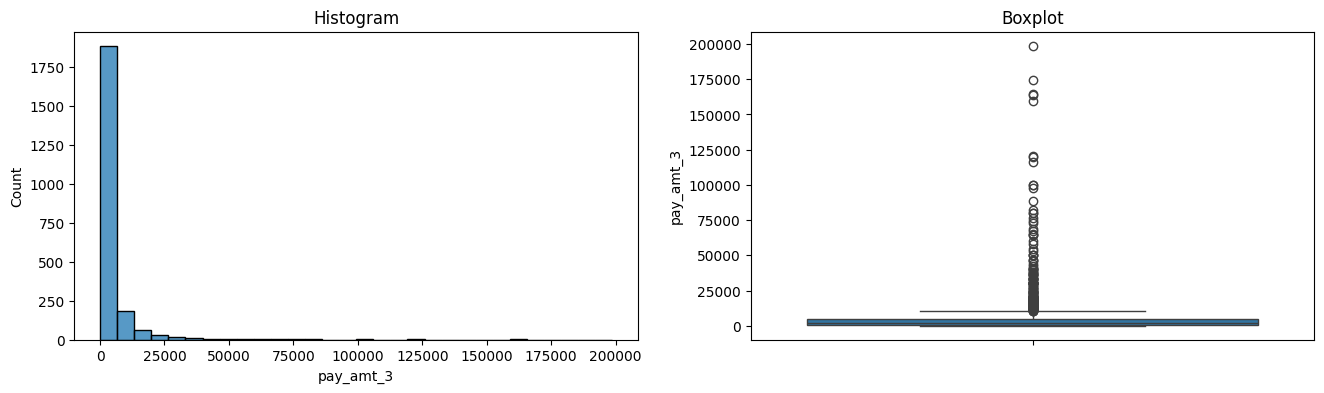

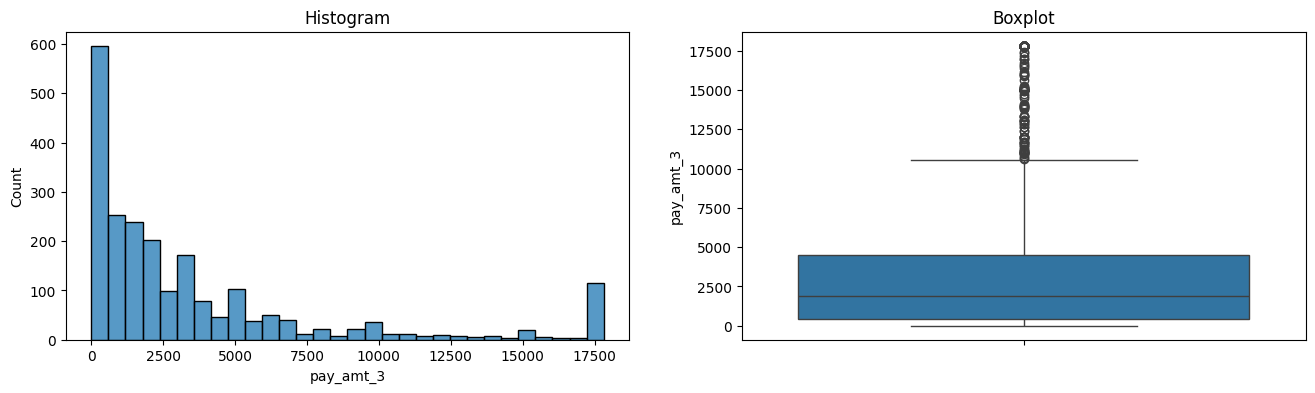

In [53]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_3')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_3')

distance - Sebelum Capping

distance - Sesudah Capping


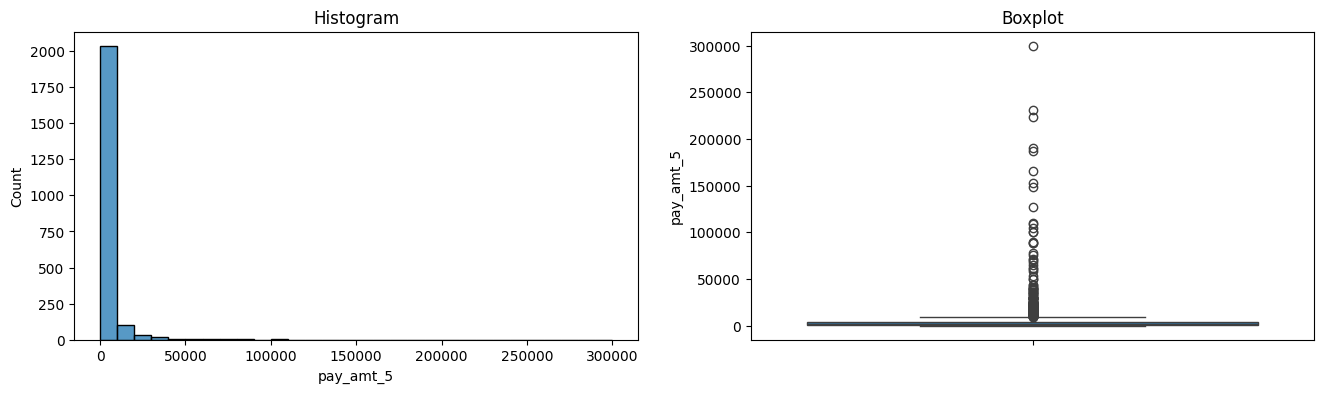

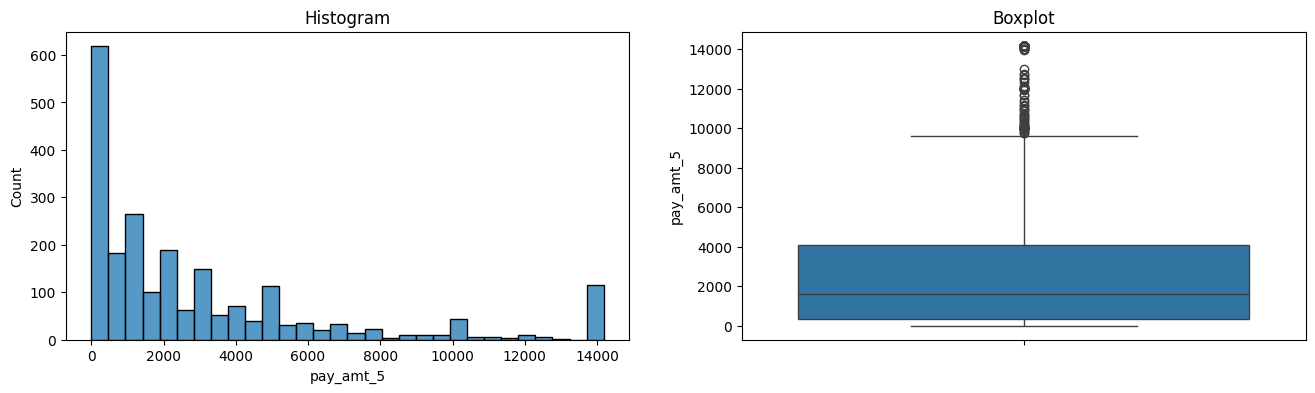

In [54]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_5')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_5')

distance - Sebelum Capping

distance - Sesudah Capping


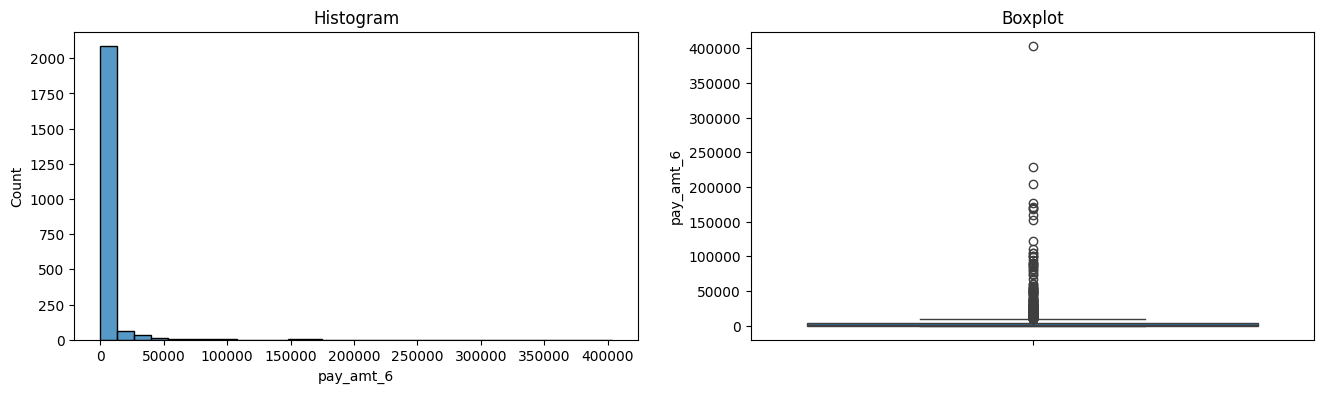

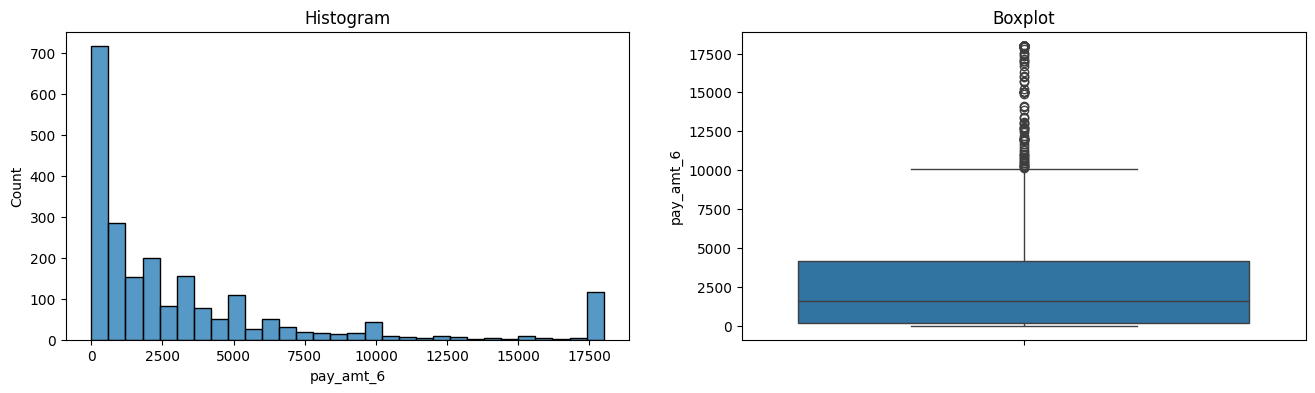

In [55]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(X_train, 'pay_amt_6')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(X_train_capped, 'pay_amt_6')

Capping sudah dilakukan dan terlihat perbedaan dari instagram

### D. Fitur Selection

Fitur selection disini menggunakan metode phik karena mampu membaca korelasi dari numerik dan categorikal.

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


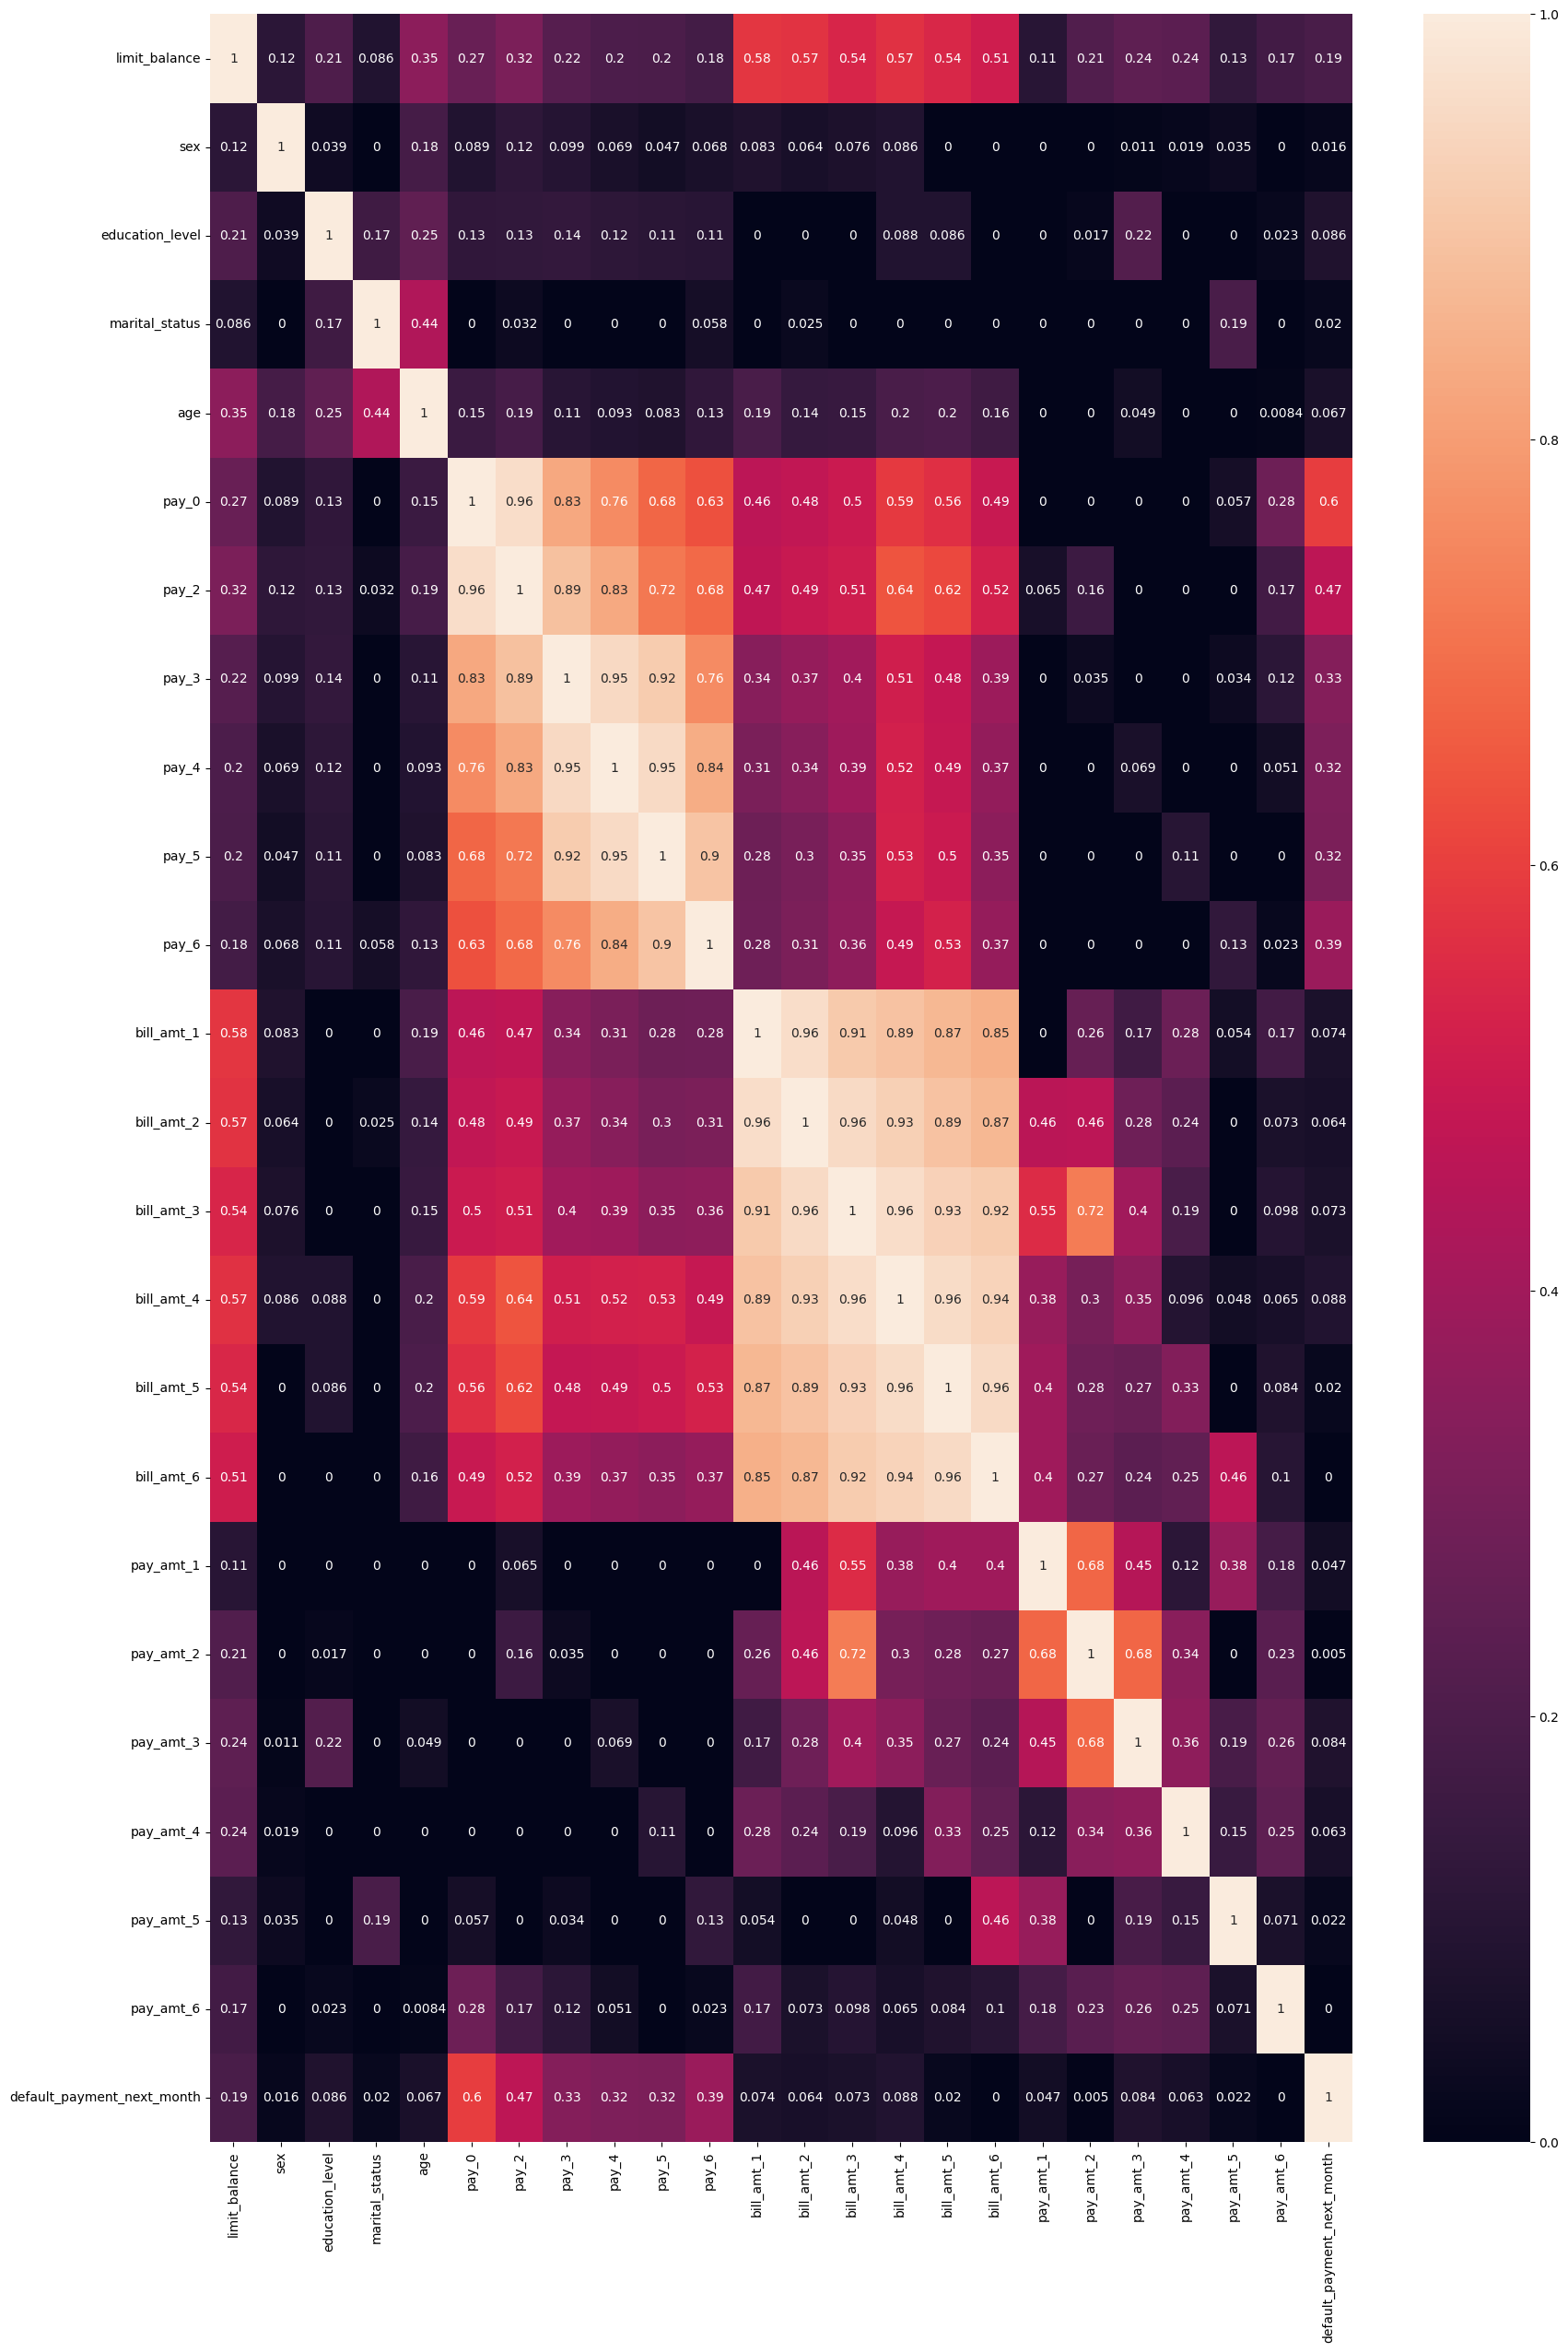

In [56]:
#menampilkan korelasi data
num_data = df_1.select_dtypes(include=[object, np.number])
corr = num_data.phik_matrix()
plt.figure(figsize=(20,30))
sns.heatmap(corr, annot=True)
plt.show()

Dari hasil nilai korelasi di atas terlihat korelasi tidak ada yang lebih dari 0,5 sehingga di putuskan untuk mengambil korelasi > 0,1, sehingga di dapatkan fiturm :
- limit_balance 
- pay_0,
- pay_2 
- pay_3 
- pay_4 
- pay_5 
- pay_6 

setelah di dapatkan fitur yang di gunakan selanjutnya kita menghapus kolom dari X_train dan y_train 

In [57]:
# hapus kolom
X_train = X_train.drop(['sex', 'education_level', 'marital_status', 'age','bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'],axis=1)
X_train.shape

(2223, 7)

In [58]:
# hapus kolom
X_test = X_test.drop(['sex', 'education_level', 'marital_status', 'age','bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'],axis=1)
X_test.head()

,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
2423,180000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2555,440000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1442,50000.0,1.0,2.0,2.0,2.0,0.0,0.0
1873,130000.0,2.0,2.0,2.0,2.0,2.0,2.0
1561,360000.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0


In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 828 to 1289
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   limit_balance  2223 non-null   float64
 1   pay_0          2223 non-null   float64
 2   pay_2          2223 non-null   float64
 3   pay_3          2223 non-null   float64
 4   pay_4          2223 non-null   float64
 5   pay_5          2223 non-null   float64
 6   pay_6          2223 non-null   float64
dtypes: float64(7)
memory usage: 138.9 KB


Sudah fix kolom akan akan kita gunakan dalam memprediksi price adalah 7 kolom, yaitu :
- limit_balance 
- pay_0,
- pay_2 
- pay_3 
- pay_4 
- pay_5 
- pay_6 

### E. Split Numerical Columns dan Categorical Columns

In [60]:
# Inisialisasi list untuk kolom numerik dan kategorikal
num_col = []
cat_col = []

# Loop melalui semua kolom dalam DataFrame
for kolom in X_train.columns:
    if X_train[kolom].min() >= -10 and X_train[kolom].max() <= 10:
        cat_col.append(kolom)
    else:
        num_col.append(kolom)

# Menampilkan daftar kolom numerik
print('Numerical columns:',num_col)

# Menampilkan daftar kolom kategorikal
print('Categorical columns:',cat_col)


Numerical columns: ['limit_balance']
Categorical columns: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


memisahkan x train

In [61]:
# Pisahkan train_set dan test_set berdasarkan jenis kolom
X_train_num = X_train_capped[num_col]
X_test_num = X_test_capped[num_col]

X_train_cat = X_train_capped[cat_col]
X_test_cat = X_test_capped[cat_col]

X_train_num.head()

,limit_balance
828,30000.0
11,400000.0
1693,150000.0
2909,100000.0
2745,20000.0


In [62]:
X_train_cat.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
828,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0
1693,-1.0,-1.0,-1.0,0.0,0.0,-2.0
2909,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
2745,-1.0,-1.0,2.0,2.0,-2.0,-2.0


Split trainset berhasil di jalankan

### F. Cek Cardinality

In [63]:
#Show cardinality
pd.set_option('display.max_colwidth', None)
values = []
for col in X_train_cat.columns:
    values.append([col, X_train_cat[col].nunique(), X_train_cat[col].unique()])

pd.DataFrame(values, columns=['Nama kolom', 'jumlah nilai unique', 'nilai unique'])

,Nama kolom,jumlah nilai unique,nilai unique
0,pay_0,11,"[0.0, -1.0, 2.0, 1.0, -2.0, 3.0, 4.0, 8.0, 6.0, 5.0, 7.0]"
1,pay_2,10,"[0.0, -1.0, 2.0, -2.0, 3.0, 4.0, 7.0, 5.0, 1.0, 6.0]"
2,pay_3,9,"[0.0, -1.0, -2.0, 2.0, 4.0, 3.0, 6.0, 7.0, 5.0]"
3,pay_4,10,"[0.0, -2.0, 2.0, -1.0, 4.0, 3.0, 5.0, 7.0, 6.0, 8.0]"
4,pay_5,9,"[0.0, -2.0, -1.0, 2.0, 3.0, 4.0, 7.0, 6.0, 5.0]"
5,pay_6,8,"[0.0, -2.0, 2.0, -1.0, 3.0, 7.0, 6.0, 4.0]"


Data merupakan low cardinality merupakandata categorical yang sudah di encode.

### G. Fiture Scalling

Tujuan utama dari fitur scaling adalah:
- Meningkatkan Kinerja Algoritma
- Mengurangi Dampak Outlier
- Interpretasi yang Lebih Mudah dll

In [64]:
#tampilkan deskripsikan X_train_num
X_train_num.describe()

,limit_balance
count,2223.000000
mean,159388.214125
std,114611.165071
min,20000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,400000.000000


Untuk menjaga data asli maka kita lakukan proses scalling dengan MinMaxScaler

In [65]:
# scalling

scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled

array([[0.42105263],
       [1.        ],
       [0.07894737],
       [0.28947368],
       [0.89473684],
       [0.02631579],
       [0.36842105],
       [0.10526316],
       [0.76315789],
       [0.23684211],
       [1.        ],
       [0.        ],
       [1.        ],
       [0.57894737],
       [0.36842105],
       [0.07894737],
       [0.68421053],
       [0.34210526],
       [0.07894737],
       [0.07894737],
       [0.18421053],
       [1.        ],
       [0.15789474],
       [0.02631579],
       [0.89473684],
       [0.        ],
       [0.13157895],
       [0.07894737],
       [0.73684211],
       [0.55263158],
       [0.39473684],
       [0.39473684],
       [0.23684211],
       [0.18421053],
       [0.39473684],
       [0.21052632],
       [0.07894737],
       [0.26315789],
       [0.5       ],
       [0.07894737],
       [0.34210526],
       [0.42105263],
       [0.60526316],
       [0.        ],
       [0.13157895],
       [0.        ],
       [0.34210526],
       [0.184

Scalling telah berhasi di lakukan

### H. Feature Encoding

Feature encoding tidak di lakukan karena seluruh fitur categorical sudah dalam bentuk encoding.

In [66]:
# tampilkan data teratas
X_train_cat.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
828,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0
1693,-1.0,-1.0,-1.0,0.0,0.0,-2.0
2909,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
2745,-1.0,-1.0,2.0,2.0,-2.0,-2.0


### I. Concate between numerical and categorical columns

Untuk mengelompokkan atau menggabungkan data dari beberapa sumber sehingga data tersebut dapat diproses, dianalisis, atau dimanipulasi lebih lanjut sebagai satu kesatuan maka kita lakukan concate

In [67]:
# Concat columns
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat], axis=1)
X_train_final

array([[ 0.02631579,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34210526, -1.        , -1.        , ...,  0.        ,
         0.        , -2.        ],
       ...,
       [ 0.18421053,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34210526,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28947368,  2.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ]])

In [68]:
# Dataframe X_train final
X_train_final = pd.DataFrame(X_train_final, columns= list(X_train_num.columns) + list((X_train_cat.columns)))
X_train_final

,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.342105,-1.0,-1.0,-1.0,0.0,0.0,-2.0
3,0.210526,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
4,0.000000,-1.0,-1.0,2.0,2.0,-2.0,-2.0
...,...,...,...,...,...,...,...
2218,0.000000,3.0,2.0,2.0,5.0,5.0,4.0
2219,0.342105,0.0,0.0,0.0,0.0,0.0,0.0
2220,0.184211,0.0,0.0,2.0,0.0,0.0,0.0
2221,0.342105,0.0,0.0,0.0,0.0,0.0,0.0


kolom sudah berhasil dilakukan concate

# vii. Model Definition

Disini dalam bagian ini menggunakan 3 model sebelum akhirnya di seleksi model mana yang paling baik di gunakan dengan pengujian matrix recall.

In [69]:
# Model definition
log_model = LogisticRegression(max_iter=1000000)
svm_model = SVC()
knn_model = KNeighborsClassifier()


# viii. Model Training

Pelatihan model (model training) ini hanya berisi code untuk melatih model dan output yang dihasilkan. Pelatihan model ini adalah langkah kunci dalam membangun model-machine learning yang efektif, karena model tersebut belajar dari data pelatihan untuk membuat prediksi yang sesuai.

## a. Cross Validation


 Digunakan untuk mengevaluasi kinerja model secara objektif dan meminimalkan risiko overfitting. Ini melibatkan pembagian data menjadi set pelatihan dan pengujian yang berbeda-beda untuk mengukur sejauh mana model mampu menggeneralisasi pada data yang belum pernah dilihat sebelumnya.

In [70]:

# define skfold
skfold=StratifiedKFold(n_splits=5)

In [71]:

# Define Cross Validation for each model
cv_log_model = cross_val_score(log_model, X_train_final, y_train, cv = skfold, scoring = 'recall')
cv_svm_model = cross_val_score(svm_model, X_train_final, y_train, cv = skfold, scoring = 'recall')
cv_knn_model = cross_val_score(knn_model, X_train_final, y_train, cv = skfold, scoring = 'recall')


In [72]:
# Finding Best model based on cros_val_score (mean)
name_model = []
cv_scores = 0
for cv,name in zip ([cv_log_model, cv_svm_model, cv_knn_model], 
                    ['log_model', 'svm_model', 'knn_model']):
    print(name)
    print('f1score - All - Cross Validation :', cv)
    print('f1score - Mean - Cross Validation :', cv.mean())
    print('f1score - Std - Cross Validation :', cv.std())
    print('f1score - Range of Test Set :', (cv.mean()-cv.std()), '-', (cv.mean()+cv.std()))
    print('-'*50)

    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else :
        pass
    
print('Best Model :', name_model)
print('Cross Val mean From Best Model :', cv_scores)

log_model
f1score - All - Cross Validation : [0.29473684 0.25263158 0.29473684 0.35106383 0.28723404]
f1score - Mean - Cross Validation : 0.296080627099664
f1score - Std - Cross Validation : 0.03160014537144774
f1score - Range of Test Set : 0.26448048172821625 - 0.3276807724711117
--------------------------------------------------
svm_model
f1score - All - Cross Validation : [0.41052632 0.32631579 0.44210526 0.42553191 0.38297872]
f1score - Mean - Cross Validation : 0.39749160134378503
f1score - Std - Cross Validation : 0.04055406664336625
f1score - Range of Test Set : 0.3569375347004188 - 0.4380456679871513
--------------------------------------------------
knn_model
f1score - All - Cross Validation : [0.42105263 0.36842105 0.38947368 0.45744681 0.42553191]
f1score - Mean - Cross Validation : 0.4123852183650616
f1score - Std - Cross Validation : 0.030777566030593378
f1score - Range of Test Set : 0.3816076523344682 - 0.443162784395655
--------------------------------------------------


Model terbaik pada project ini adalah knn_model.

# a. Baseline Model

Model sederhana yang digunakan sebagai dasar perbandingan atau acuan dalam pengembangan model machine learning yang lebih kompleks. Setelah mendapatakan model terbaik maka kita gunakan.

In [73]:
# Baseline Model menggunakan Random Forest Algorithm

knn_model.fit(X_train_final, y_train)

KNeighborsClassifier()

Recall Score - Train Set  :  0.4989429175475687 

Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1750
           1       0.68      0.50      0.58       473

    accuracy                           0.84      2223
   macro avg       0.78      0.72      0.74      2223
weighted avg       0.83      0.84      0.83      2223
 

Confusion Matrix      : 


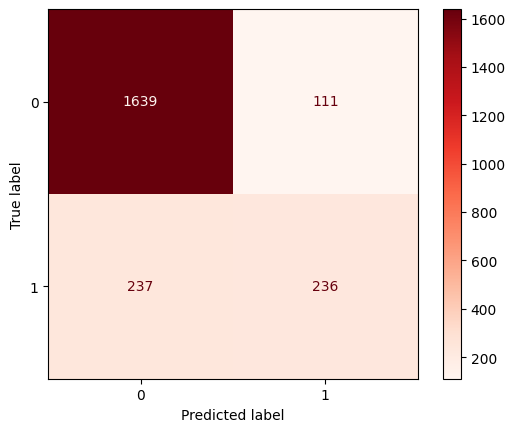

In [74]:
# Check Performance Model against Train-Set

y_pred_train = knn_model.predict(X_train_final)

print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_model.fit(X_train_final, y_train)
, X_train_final, y_train, cmap='Reds'))

Hasil recall score adalah 0.4989. Recall adalah metrik evaluasi yang mengukur sejauh mana model dapat mengidentifikasi positif sejati (kelas 1) dari total kasus positif. Dalam konteks ini, model hanya mampu mengidentifikasi 49.89% dari semua kasus kelas 1 di dalam data pelatihan.

# c. Hyper Parameter Tuning

Hyperparameter dari model knn dilakukan dengan random search dengan tujuan saat proses dilakukan tidak membutuhkan waktu yang terlalu lama.

Dilakukan untuk mencari kombinasi parameter terbaik untuk suatu model.

In [75]:
# Hyperparameter Tuning : Random Search

# Define Hyperparameters for KNN
n_neighbors = list(range(1, 15))  # You can adjust the range as needed
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'chebyshev']
random_search_params = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

random_search_params

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'weights': ['uniform', 'distance'],
 'metric': ['euclidean', 'manhattan', 'chebyshev']}

Didapatkan kombinasi terbaik.

In [76]:
# Train with Random Search

knn_random = RandomizedSearchCV(estimator=knn_model,
                                 param_distributions=random_search_params,
                                 n_iter=50,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='recall')
knn_random.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14],
                                        'weights': ['uniform', 'distance']},
                   random_state=46, scoring='recall')

Cek parameter terbaik

In [77]:
# Get Best Hyperparameters
knn_random.best_params_

{'weights': 'distance', 'n_neighbors': 1, 'metric': 'manhattan'}

Masukan parameter terbaik ke model

In [78]:
# Get Best Estimator

knn_random_best = knn_random.best_estimator_

# ix. Model Evaluation

Recall Score - train Set   :  0.7420718816067653 

Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1750
           1       0.73      0.74      0.73       473

    accuracy                           0.89      2223
   macro avg       0.83      0.83      0.83      2223
weighted avg       0.89      0.89      0.89      2223
 

Confusion Matrix      : 


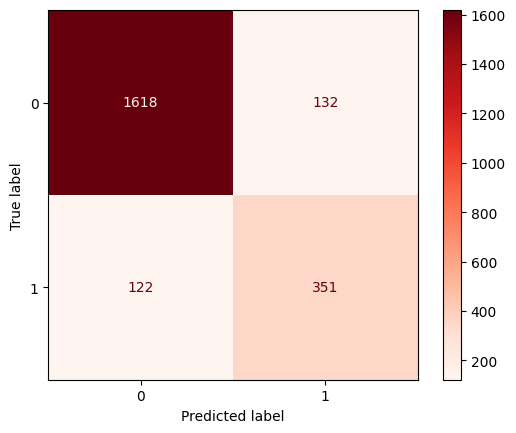

In [79]:
# Check Performance Model against train-Set

y_pred_train = knn_random_best.predict(X_train_final)

print('Recall Score - train Set   : ', recall_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_random_best, X_train_final, y_train, cmap='Reds'))

Recall Score - Test Set   :  0.42592592592592593 

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       579
           1       0.41      0.43      0.42       162

    accuracy                           0.74       741
   macro avg       0.62      0.63      0.62       741
weighted avg       0.74      0.74      0.74       741
 

Confusion Matrix      : 


c:\Users\MASTER\miniconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\MASTER\miniconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


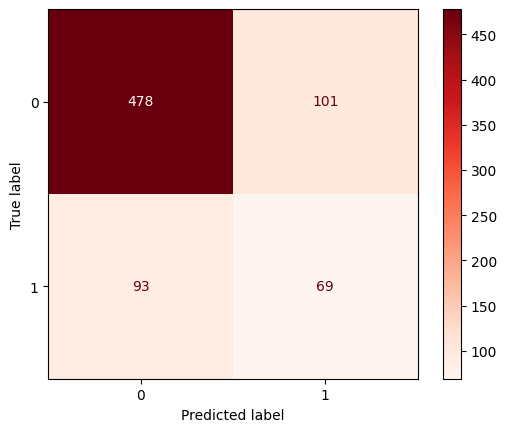

In [80]:
# Check Performance Model against Test-Set

y_pred_test = knn_random_best.predict(X_test_final)

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_random_best, X_test_final, y_test, cmap='Reds'))

Recall score train = 0,74,  Recall score test = 0.42Recall Score Train = 0.74: Ini berarti bahwa pada dataset pelatihan, model mampu mengidentifikasi dengan benar 74% dari semua kasus positif (klasifikasi 1). Ini adalah kinerja model pada data yang digunakan untuk pelatihan.

Recall Score Test = 0.42: Ini berarti bahwa pada dataset pengujian, model hanya mampu mengidentifikasi dengan benar 42% dari semua kasus positif (klasifikasi 1). Ini adalah kinerja model pada data yang belum pernah dilihat sebelumnya (data pengujian).

Perbedaan antara recall score pada data pelatihan dan data pengujian bisa mengindikasikan overfitting. Jika model memiliki recall yang lebih tinggi pada data pelatihan daripada pada data pengujian, maka model tersebut mungkin telah "memorakannya" dengan baik pada data pelatihan, tetapi mungkin tidak generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya. Hal ini bisa menjadi tanda bahwa model perlu penyesuaian agar lebih baik dalam menggeneralisasi pada data baru.

dilihat dari perbandingan f1 score test dan train dapat disimpulkan bahwa mesin learning termasuk ke dalam over fit.

In [81]:
perbandingan = pd.DataFrame({'aktual': y_test,
                             'prediksi': y_pred_test})

perbandingan

,aktual,prediksi
2423,0,0
2555,0,0
1442,1,0
1873,1,1
1561,0,0
...,...,...
1728,1,1
1999,1,0
2893,0,0
1525,0,0


# ix. Model Saving



 Proses penyimpanan model penting karena melatih model bisa memakan waktu dan sumber daya yang berharga, dan dengan menyimpan model, Anda dapat dengan cepat menerapkannya pada data baru.

In [82]:
#simpan file

with open('knn_random_best.pkl', 'wb') as file_1: #wb = write binnary
    pickle.dump(knn_random_best,file_1)

with open('scaler.pkl','wb') as file_2:
    pickle.dump(scaler, file_2)

with open('num_col.txt','w') as file_3:
    json.dump(num_col, file_3)

with open('cat_col.txt','w') as file_4:
    json.dump(cat_col, file_4)

# x. Model Inference

Model inference dibuat di notebook berbeda dengan nama **Creditcard_default_inf.ipynb**

# xi. Kesimpulan

Dataset bernama [credit_card_default]('https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-400803&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default'), dengan rincian: 
- Terdiri Data terdiri dari 24 kolom yaitu : 'limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', pay_4', 'pay_5', 'pay_6', 'bill_amt_1','bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6','pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month'.
- Bertipe Integer(64) 4 kolom , 
- Float(64) 20 kolom, 
- Jumlah 2.965 baris.

Tujuan utama adalah mengembangkan model prediksi yang akurat untuk mengidentifikasi pelanggan yang berpotensi gagal bayar.

Dari data yang di miliki dan di lakukan proses EDA insight yang dapat di ambil adalah :
Insight yang dapat di ambil dari proses EDA ini adalah :
- Terlihat deafault payment di dominasi dengan 0 yang artinya yang membayar lebih banyak dari pada yang gagal bayar.
- Dari diagram terlihat bahwa pengguna kartu yang melakukan pembayaran lebih banyak dari pada yang gagal bayar.
- Dari diagram terlihat pengguna kartu kredit adalah pria.
- Dari diagram terlihat pengguna kartu kredit dengan status marriage dalah yang paling banyak.
- Dari diagram terlihat bahwa edicatuion lovel paling banyak adalah lulusan Universitas.


Dalam project ini fitur yang digunakan untuk membuat model prediksi adalah :
- limit_balance 
- pay_0,
- pay_2 
- pay_3 
- pay_4 
- pay_5 
- pay_6 


Recall score train = 0,74,  Recall score test = 0.42Recall Score Train = 0.74: Ini berarti bahwa pada dataset pelatihan, model mampu mengidentifikasi dengan benar 74% dari semua kasus positif (klasifikasi 1). Ini adalah kinerja model pada data yang digunakan untuk pelatihan.

Recall Score Test = 0.42: Ini berarti bahwa pada dataset pengujian, model hanya mampu mengidentifikasi dengan benar 42% dari semua kasus positif (klasifikasi 1). Ini adalah kinerja model pada data yang belum pernah dilihat sebelumnya (data pengujian).

Perbedaan antara recall score pada data pelatihan dan data pengujian bisa mengindikasikan overfitting. Jika model memiliki recall yang lebih tinggi pada data pelatihan daripada pada data pengujian, maka model tersebut mungkin telah "memorakannya" dengan baik pada data pelatihan, tetapi mungkin tidak generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya. Hal ini bisa menjadi tanda bahwa model perlu penyesuaian agar lebih baik dalam menggeneralisasi pada data baru.

untuk itu dapat di simpulkan bahwa model termasuk overfit.

Keunggulan dari project ini adalah membandingkan 3 model yaitu di antara Logistic Regression, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN) yang di buat dengan matrix recal dan hasil yang di dapat adalah knn merupakan model terbaik yang di buat model dalam project ini.

kelemahan dari project ini masih tergolong overfit.

selanjutnya rekomendasi untuk yang ingin melakukan project ini adalah menyelesaikan bagaimana caranya agar hasil tidak overfit mungkin dengan model dan matrix yang lain selain yang di gunakan dalam project ini.